# Проект e-learning: вариант 2
##  Anastasiia Sibiriakova (a_sibiriakova)
###  Поток 15.08

In [1]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

### Первые шаги :
   - импортируем данные
   - предобрабатываем данные
   - сформулируем, что должно считаться курсом

***

данные находятся по ссылке на Яндекс диске поэтому нужна предобработка коротких ссылок

эта функция позволяет преобразовать короткую ссылку в понятный для пандас url для доступа к файлу

In [2]:
# из интернета

import requests 
from urllib.parse import urlencode 
 
def get_csv_from_yandex(link):    
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    
    # получаем url 
    final_url = base_url + urlencode(dict(public_key=link)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    
    return download_url

In [3]:
# сохраняем короткие пути до файлов в переменные
assessments_link = 'https://disk.yandex.ru/d/PBW7aUHGuodFDA'
courses_link = 'https://disk.yandex.ru/d/m0Z6QYNT46f9tQ'
studentAssessment_link = 'https://disk.yandex.ru/d/lsmdbYB0iM7p3w'
studentRegistration_link = 'https://disk.yandex.ru/d/Yse4Y6RJqg_WaA'

***

**assessments** — содержит информацию об оценках в тесте. 
Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).

- `code_module` — идентификационный код предмета.
- `code_presentation` — семестр (Идентификационный код).
- `id_assessment` — тест (Идентификационный номер ассессмента).
- `assessment_type` — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).
- `date` — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).
- `weight` — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

загружаем данные в df 

In [4]:
# загружаем данные в df 
assessments_df = pd.read_csv(get_csv_from_yandex(assessments_link)) 

assessments_df.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


смотрим размер датафрейма

данных немного:
- либо мало предметов в исследуемой образовательной платформе
- либо данные за небольшой временной отрезок
- либо вообще мало тестов предусмотрено для студентов

будем разбираться

In [5]:
# смотрим размер датафрейма
assessments_df.shape

(206, 6)

смотрим типы данных - все ОК, преобразований не требуется

In [6]:
# смотрим типы данных
assessments_df.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object

смотрим количество пропущенных значений

есть пустые date, посмотрим для каких тестов они пустые

In [7]:
# смотрим количество пропущенных значений
assessments_df.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

только тип теста "Exam" с пустой датой, возможно так предусмотрено логикой исследуемой обучающей платформы

In [8]:
# группируем по пустой дате,смотрим уникальные значения в поле тип теста
assessments_df.query('date != date')['assessment_type'].unique()

array(['Exam'], dtype=object)

смотрим количество уникальных значений в столбцах

видим, что всего 7 курсов, 4 семестра и 3 типа тестов, от отчасти объясняет небольшое количество данных в текущем датафрейме

In [9]:
# смотрим количество уникальных значений в столбцах
assessments_df.nunique()

code_module            7
code_presentation      4
id_assessment        206
assessment_type        3
date                  74
weight                24
dtype: int64

смотрим описательные статистики по разным типам полей

глазу особо зацепиться не за что, идем дальше

In [10]:
# смотрим описательные статистики
assessments_df.describe()

,id_assessment,date,weight
count,206.000000,195.000000,206.000000
mean,26473.975728,145.005128,20.873786
std,10098.625521,76.001119,30.384224
min,1752.000000,12.000000,0.000000
25%,15023.250000,71.000000,0.000000
50%,25364.500000,152.000000,12.500000
75%,34891.750000,222.000000,24.250000
max,40088.000000,261.000000,100.000000


In [11]:
# смотрим описательные статистики по столбцам типа object
assessments_df.describe(include='object')

,code_module,code_presentation,assessment_type
count,206,206,206
unique,7,4,3
top,FFF,2014J,TMA
freq,52,57,106


посмотрим какие и сколько видов тестов сдают студенты по предметам

из интересного:

для предмета CCC в семестрах 2014B и 2014J предполагается 2 экзамена

In [12]:
# группируем и считаем количество тестов, переворачиваем полученную таблицу
assessments_df.groupby(['code_module','code_presentation','assessment_type'], as_index = False) \
    .agg({'id_assessment':'count'}) \
    .pivot(index = ['code_module','code_presentation'], columns='assessment_type', values='id_assessment')

assessment_type                CMA  Exam  TMA
code_module code_presentation                
AAA         2013J              NaN   1.0  5.0
            2014J              NaN   1.0  5.0
BBB         2013B              5.0   1.0  6.0
            2013J              5.0   1.0  6.0
            2014B              5.0   1.0  6.0
            2014J              NaN   1.0  5.0
CCC         2014B              4.0   2.0  4.0
            2014J              4.0   2.0  4.0
DDD         2013B              7.0   1.0  6.0
            2013J              NaN   1.0  6.0
            2014B              NaN   1.0  6.0
            2014J              NaN   1.0  6.0
EEE         2013J              NaN   1.0  4.0
            2014B              NaN   1.0  4.0
            2014J              NaN   1.0  4.0
FFF         2013B              7.0   1.0  5.0
            2013J              7.0   1.0  5.0
            2014B              7.0   1.0  5.0
            2014J              7.0   1.0  5.0
GGG         2013J              6.0   1.0  3.0
            2014B              6.0   1.0  3.0
            2014J              6.0   1.0  3.0

смотрим как по времени распределены тесты по предмету

In [13]:
# отбираем предмет и семестр, сортируем по дате
assessments_df.query('code_module == "BBB" & code_presentation == "2014B"') \
    .sort_values('date')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
41,BBB,2014B,15008,TMA,12.0,5.0
42,BBB,2014B,15009,TMA,40.0,18.0
36,BBB,2014B,15015,CMA,47.0,1.0
37,BBB,2014B,15016,CMA,82.0,1.0
43,BBB,2014B,15010,TMA,82.0,18.0
38,BBB,2014B,15017,CMA,117.0,1.0
44,BBB,2014B,15011,TMA,117.0,18.0
39,BBB,2014B,15018,CMA,152.0,1.0
45,BBB,2014B,15012,TMA,152.0,18.0
40,BBB,2014B,15019,CMA,194.0,1.0


***

**courses** — содержит список предметов по семестрам.

- `code_module` — предмет (идентификационный код).
- `code_presentation` — семестр (идентификационный код).
- `module_presentation_length` — продолжительность семестра в днях.

загружаем файл в df 

In [14]:
# загружаем файл в df 
courses_df = pd.read_csv(get_csv_from_yandex(courses_link)) 

courses_df.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [15]:
# смотрим размер датафрейма
courses_df.shape

(22, 3)

смотрим типы данных - все ОК, преобразований не требуется

In [16]:
# смотрим типы данных
courses_df.dtypes

code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

смотрим количество пропущенных значений и количество уникальных значений в столбцах

In [17]:
# смотрим количество пропущенных значений
courses_df.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [18]:
# смотрим количество уникальных значений в столбцах
courses_df.nunique()

code_module                   7
code_presentation             4
module_presentation_length    7
dtype: int64

смотрим описательные статистики по разным типам полей

средняя продолжительность семестра 256 дней, что-то многовато, больше, чем рабочих дней в году, странные семестры

In [19]:
# смотрим описательные статистики
courses_df.describe()

,module_presentation_length
count,22.000000
mean,255.545455
std,13.654677
min,234.000000
25%,241.000000
50%,261.500000
75%,268.000000
max,269.000000


In [20]:
# смотрим описательные статистики по столбцам типа object
# ничего интересного
courses_df.describe(include='object')

,code_module,code_presentation
count,22,22
unique,7,4
top,FFF,2014J
freq,4,7


***

**studentAssessment** — содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

- `id_assessment` — тест (идентификационный номер).
- `id_student` — идентификационный номер студента.
- `date_submitted` — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.
- `is_banked` — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).
- `score` — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

загружаем файл в df 

In [21]:
# загружаем файл в df 
studentAssessment_df = pd.read_csv(get_csv_from_yandex(studentAssessment_link)) 

studentAssessment_df.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [22]:
# смотрим размер датафрейма
studentAssessment_df.shape

(173912, 5)

смотрим типы данных - все ОК, преобразований не требуется

In [23]:
# смотрим типы данных
studentAssessment_df.dtypes

id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

смотрим количество пропущенных значений

пустых score 173, возможно это не проверенные работы

In [24]:
# смотрим количество пропущенных значений
studentAssessment_df.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

да, наше предположение верно - это не проверенные работы. Тип теста "TMA" требует оценки преподавателя

In [25]:
# отбираем пустые строки с оценками,
# объединяем с таблицей assessments_df, чтобы подтянуть тип теста, смотрим уникальные
studentAssessment_df.query('score != score').merge(assessments_df, on='id_assessment')['assessment_type'].unique()

array(['TMA'], dtype=object)

In [26]:
# смотрим количество уникальных значений в столбцах
studentAssessment_df.nunique()

id_assessment       188
id_student        23369
date_submitted      312
is_banked             2
score               101
dtype: int64

смотрим описательные статистики

средняя оценка 76, 50% студентов получают оценку выше 80, очень хорошо, умные студенты здесь учатся, ну либо тесты несложные

интересно, что есть отрицательные даты отправки тестов на проверку, то есть отправлены до начала семестра

In [27]:
# смотрим описательные статистики
studentAssessment_df.describe()

,id_assessment,id_student,date_submitted,is_banked,score
count,173912.000000,1.739120e+05,173912.000000,173912.000000,173739.000000
mean,26553.803556,7.051507e+05,116.032942,0.010977,75.799573
std,8829.784254,5.523952e+05,71.484148,0.104194,18.798107
min,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000
25%,15022.000000,5.044290e+05,51.000000,0.000000,65.000000
50%,25359.000000,5.852080e+05,116.000000,0.000000,80.000000
75%,34883.000000,6.344980e+05,173.000000,0.000000,90.000000
max,37443.000000,2.698588e+06,608.000000,1.000000,100.000000


ага, с отрицательными датами в основном перезачеты, это понятно

In [28]:
# отбираем с отрицательной датой, группируем по перезачету и считаем количество
studentAssessment_df.query('date_submitted < 0')\
    .groupby('is_banked', as_index = False) \
    .agg({'id_assessment':'count'})

,is_banked,id_assessment
0,0,148
1,1,1909


смотрим внимательнее, где нет перезачета 

с отрицательными датами (то есть тесты были отправлены на проверку до начала семестра) только 'TMA', 'CMA', ну хоть не экзамены

но все равно странно, какой-то баг, нужно сказать разработчикам, чтобы проверили

In [29]:
# смотрим внимательнее, где нет перезачета и отрицательная дата отправки
# объединяем с таблицей assessments_df, чтобы подтянуть тип теста, смотрим уникальные
studentAssessment_df.query('date_submitted < 0 & is_banked == 0') \
    .merge(assessments_df, on = 'id_assessment')['assessment_type'].unique()

array(['TMA', 'CMA'], dtype=object)

***

**studentRegistration** — содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.

- `code_module` — предмет (идентификационный код).
- `code_presentation` — семестр (идентификационный код)
- `id_student` — идентификационный номер студента.
- `date_registration` — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).
- `date_unregistration` — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

загружаем файл в df

In [30]:
# загружаем файл в df 
studentRegistration_df = pd.read_csv(get_csv_from_yandex(studentRegistration_link)) 

studentRegistration_df.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [31]:
# смотрим размер датафрейма
studentRegistration_df.shape

(32593, 5)

смотрим типы данных - все ОК, преобразований не требуется

In [32]:
# смотрим типы данных
studentRegistration_df.dtypes

code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object

смотрим количество пропущенных значений

странно, есть 45 записей с пустой датой регистрации

In [33]:
# смотрим количество пропущенных значений
studentRegistration_df.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

проверим сколько из них были с перезачетами тестов\экзаменов, может они переведены с других потоков и поэтому дата регистрации пустая

с перезачетами очень мало, дело не в перезачетах

общее число студентов больше, потому что некоторые сдавали больше одного теста\экзамена

но еще это значит, что студенты с пустой датой регистрации фактически обучались

In [34]:
# отбираем с пустой датой регистрации
# объедняем с таблицей studentAssessment_df, группируем по перезачетам и считаем количество таких студентов
studentRegistration_df.query('date_registration != date_registration') \
    .merge(studentAssessment_df, on='id_student') \
    .groupby('is_banked', as_index=False) \
    .agg({'id_student':'count'})

,is_banked,id_student
0,0,49
1,1,4


из 45 записей с пустой датой регистрации 39 с отмененной регистрацией

In [35]:
# отбираем с пустой датой регистрации и с отмененной регистрацией 
studentRegistration_df \
    .query('date_registration != date_registration & date_unregistration == date_unregistration').shape[0]

39

думаю, будет уместно таким студентам в поле дата регистрации записать дату отмены

будем считать, что они зарегистрировались и отменили в тот же день

In [36]:
# для строк, где заполнена дата отмены в пустое поле даты регистрации записываем дату отмены
studentRegistration_df['date_registration'].fillna(studentRegistration_df['date_unregistration'], inplace=True)

# осталось 6 записей
studentRegistration_df['date_registration'].isna().sum()

6

проверим сколько из них сдавали тесты\экзамены

In [37]:
# отбираем с пустой датой регистрации
# объедняем с таблицей studentAssessment_df, смотрим сколько тестов сдали такие студенты
studentRegistration_df.query('date_registration != date_registration') \
    .merge(studentAssessment_df, on='id_student').shape[0]

0

то есть они не сдавали ни одного теста\экзамена

можем удалить эти 6 записей, на качество нашего анализа это не повлияет

In [38]:
# удаляем оставшиеся записи с пустой регистрацией
studentRegistration_df = studentRegistration_df.dropna(subset=['date_registration'])

In [39]:
# проверяем
# все ОК, странных студентов не осталось
studentRegistration_df['date_registration'].isna().sum()

0

смотрим количество уникальных значений в столбцах

число уникальных студентов меньше чем записей в датафрейме, значит какие-то студенты записались больше чем на 1 предмет

In [40]:
# смотрим количество уникальных значений в столбцах
studentRegistration_df.nunique()

code_module                7
code_presentation          4
id_student             28780
date_registration        334
date_unregistration      416
dtype: int64

посмотрим на этих студентов

In [41]:
# группируем по студенту, считаем на сколько предметов он зарегистрировался
# сортируем по убыванию, отбираем где больше 1
studentRegistration_df.groupby('id_student', as_index = False).agg({'code_module': 'count'}) \
    .sort_values('code_module', ascending = False).query('code_module > 1').head()

,id_student,code_module
13484,584077,5
14720,592939,4
9176,542562,4
18829,624126,4
12056,572154,4


посмотрим внимательнее на студента 584077

странный студент, записался на предмет CCC почти за год до начала и отменил его через 3 месяца после старта учебы

он отменил регистрации со всех предметов, значит не закончил их

In [42]:
# посмотрим внимательнее на студента 584077
studentRegistration_df.query('id_student == 584077')

,code_module,code_presentation,id_student,date_registration,date_unregistration
9587,CCC,2014B,584077,-260.0,89.0
11525,CCC,2014J,584077,-53.0,51.0
15596,DDD,2013J,584077,-148.0,66.0
16828,DDD,2014B,584077,17.0,89.0
18139,DDD,2014J,584077,-60.0,44.0


посмотрим сдавал ли он тесты вообще

ага, тесты сдавал, но всегда с опозданием date_submitted > date

ну да ладно, странный студент, оставим его в покое

In [43]:
# посмотрим сдавал ли он тесты вообще
studentAssessment_df.query('id_student == 584077').merge(assessments_df, on='id_assessment')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,24282,584077,36,0,66.0,CCC,2014B,TMA,32.0,9.0
1,24286,584077,20,0,50.0,CCC,2014B,CMA,18.0,2.0
2,24287,584077,69,0,54.0,CCC,2014B,CMA,67.0,7.0
3,24295,584077,21,0,56.0,CCC,2014J,CMA,18.0,2.0
4,25348,584077,26,0,55.0,DDD,2013J,TMA,25.0,10.0
5,25355,584077,32,0,65.0,DDD,2014B,TMA,25.0,10.0
6,25356,584077,53,0,73.0,DDD,2014B,TMA,53.0,12.5
7,25357,584077,88,0,35.0,DDD,2014B,TMA,74.0,17.5


смотрим описательные статистики для разных типов полей

среднее время регистрации на предмет за 69 дней, среднее время отмены регистрации - через 50 дней после начала семестра

In [44]:
# смотрим описательные статистики
studentRegistration_df.describe()

,id_student,date_registration,date_unregistration
count,3.258700e+04,32587.000000,10072.000000
mean,7.064299e+05,-69.428330,49.757645
std,5.487948e+05,49.321145,82.460890
min,3.733000e+03,-365.000000,-365.000000
25%,5.085545e+05,-101.000000,-2.000000
50%,5.902890e+05,-57.000000,27.000000
75%,6.444230e+05,-29.000000,109.000000
max,2.716795e+06,167.000000,444.000000


In [45]:
# смотрим описательные статистики по столбцам типа object
# ничего интресного
studentRegistration_df.describe(include = 'object')

,code_module,code_presentation
count,32587,32587
unique,7,4
top,BBB,2014J
freq,7908,11259


***

### Что считаем курсом

Курсом в данном исследовании будем считать связку "предмет в семестре". Предмет с одинаковым именем, но в разных семестрах будем считать разными курсами.

Почему так:
1. Средняя длительность предмета в семестре 256 дней - вполне достойный срок, чтобы считать такой предмет курсом. 
2. Итоговым тестом по каждому предмету является финальный экзамен. То есть у нас нет предметов, где достаточно зачета для окончания. Это тоже говорит в пользу того, чтобы считать предмет курсом.
3. На предмете в среднем начинают обучение 1340 студентов (учитываем только тех, кто либо завершил предмет, либо отменил регистрацию уже после старта обучения), весомое количество студентов дает нам еще одно основание считать предмет курсом.
4. От семестра к семестру содержание предмета перерабатывается/изменяется, этот вывод можно сделать по таблице ниже: может поменяться количество и состав тестов, сроки их сдачи и вес теста в оценке.

таблица с данными о количестве итоговых экзаменов по каждому курсу

In [46]:
# отбираем только экзамены, группируем по предмету и семестру, считаем количество экзаменов
assessments_exams_count = assessments_df.query('assessment_type == "Exam"') \
        .groupby(['code_module', 'code_presentation'], as_index = False) \
        .agg({'id_assessment':'count'}) \
        .rename(columns={'id_assessment':'exam_count'})
# выводим все, мы знаем, что записей мало
assessments_exams_count

,code_module,code_presentation,exam_count
0,AAA,2013J,1
1,AAA,2014J,1
2,BBB,2013B,1
3,BBB,2013J,1
4,BBB,2014B,1
5,BBB,2014J,1
6,CCC,2014B,2
7,CCC,2014J,2
8,DDD,2013B,1
9,DDD,2013J,1


таблица с данными о количестве студентов, начавших обучение по каждому курсу

In [47]:
# отбираем с пустой датой отмены или с отменой после начала семестра
# группируем по предмету и семестру, считаем количество студентов
studentRegistration_students_count = studentRegistration_df \
            .query('date_unregistration != date_unregistration | date_unregistration > 0') \
            .groupby(['code_module', 'code_presentation'], as_index = False) \
            .agg({'id_student':'count'}) \
            .rename(columns={'id_student':'student_count'})

studentRegistration_students_count.head()

,code_module,code_presentation,student_count
0,AAA,2013J,376
1,AAA,2014J,352
2,BBB,2013B,1643
3,BBB,2013J,1901
4,BBB,2014B,1324


сводная таблица с данными по курсам

In [48]:
# сводная таблица с данными по курсам
courses_merge = courses_df.merge(assessments_exams_count, on=['code_module', 'code_presentation']) \
        .merge(studentRegistration_students_count, on=['code_module', 'code_presentation'])

courses_merge.head()

,code_module,code_presentation,module_presentation_length,exam_count,student_count
0,AAA,2013J,268,1,376
1,AAA,2014J,269,1,352
2,BBB,2013J,268,1,1901
3,BBB,2014J,262,1,2052
4,BBB,2013B,240,1,1643


средняя продолжительность 256 дней, среднее количество студентов 1340, экзамен в основном 1

In [49]:
# средние значения по столбцам
courses_merge.mean()

module_presentation_length     255.545455
exam_count                       1.090909
student_count                 1340.454545
dtype: float64

смотрим, что еще можно узнать про предметы

от семестра к семестру содержание предметы перерабатываются/изменяются, этот вывод можно сделать по таблице ниже: 

может поменятся количество и состав тестов (например, BBB и DDD), 

сроки их сдачи (например, CCC) и 

вес теста в оценке (например, BBB, CCC и DDD).

In [50]:
# группируем по предмету, семестру, типу теста
# считаем количество типов тестов, дату теста, вес оценки
assessments_df \
    .groupby(['code_module','code_presentation','assessment_type'], as_index=False) \
    .agg({'id_assessment':'count', 'date':'mean', 'weight':'mean'}) \
    .sort_values(['code_module','code_presentation','date']) \
    .pivot(index=['code_module','code_presentation'],
           columns='assessment_type',
           values=['id_assessment', 'date', 'weight'])

id_assessment                  date         \
assessment_type                         CMA Exam  TMA         CMA   Exam   
code_module code_presentation                                              
AAA         2013J                       NaN  1.0  5.0         NaN    NaN   
            2014J                       NaN  1.0  5.0         NaN    NaN   
BBB         2013B                       5.0  1.0  6.0  122.600000    NaN   
            2013J                       5.0  1.0  6.0  131.000000    NaN   
            2014B                       5.0  1.0  6.0  118.400000    NaN   
            2014J                       NaN  1.0  5.0         NaN    NaN   
CCC         2014B                       4.0  2.0  4.0  107.250000    NaN   
            2014J                       4.0  2.0  4.0  110.750000    NaN   
DDD         2013B                       7.0  1.0  6.0  113.142857  240.0   
            2013J                       NaN  1.0  6.0         NaN  261.0   
            2014B                       NaN  1.0  6.0         NaN  241.0   
            2014J                       NaN  1.0  6.0         NaN    NaN   
EEE         2013J                       NaN  1.0  4.0         NaN  235.0   
            2014B                       NaN  1.0  4.0         NaN  228.0   
            2014J                       NaN  1.0  4.0         NaN  235.0   
FFF         2013B                       7.0  1.0  5.0  222.000000  222.0   
            2013J                       7.0  1.0  5.0  236.000000  236.0   
            2014B                       7.0  1.0  5.0  227.000000  227.0   
            2014J                       7.0  1.0  5.0  241.000000  241.0   
GGG         2013J                       6.0  1.0  3.0  229.000000  229.0   
            2014B                       6.0  1.0  3.0  222.000000  222.0   
            2014J                       6.0  1.0  3.0  229.000000  229.0   

                                             weight                    
assessment_type                       TMA       CMA   Exam        TMA  
code_module code_presentation                                          
AAA         2013J              114.200000       NaN  100.0  20.000000  
            2014J              114.200000       NaN  100.0  20.000000  
BBB         2013B              104.166667  1.000000  100.0  15.833333  
            2013J              111.166667  1.000000  100.0  15.833333  
            2014B               99.500000  1.000000  100.0  15.833333  
            2014J              107.200000       NaN  100.0  20.000000  
CCC         2014B              121.250000  6.250000  100.0  18.750000  
            2014J              126.500000  6.250000  100.0  18.750000  
DDD         2013B              104.333333  3.571429  100.0  12.500000  
            2013J              110.166667       NaN  100.0  16.666667  
            2014B              104.333333       NaN  100.0  16.666667  
            2014J               95.833333       NaN  100.0  16.666667  
EEE         2013J               96.000000       NaN  100.0  25.000000  
            2014B               92.500000       NaN  100.0  25.000000  
            2014J               99.500000       NaN  100.0  25.000000  
FFF         2013B               90.400000  0.000000  100.0  20.000000  
            2013J               93.200000  0.000000  100.0  20.000000  
            2014B               92.600000  0.000000  100.0  20.000000  
            2014J              101.000000  0.000000  100.0  20.000000  
GGG         2013J              119.333333  0.000000  100.0   0.000000  
            2014B              114.666667  0.000000  100.0   0.000000  
            2014J              119.333333  0.000000  100.0   0.000000

***

***

### 1. Сколько студентов успешно сдали только один курс? 
(Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).

Я бы уточнила формулировку вопроса: здесь под "успешно сдали только один курс" будем понимать "закончили только один курс, успешно сдав все экзамены, предполагаемые программой курса"

### Расчеты

результирующий датафрейм с результатами оценок студентов, где тип теста Экзамен

In [51]:
# объединяем таблицы по id Экзамена
assessments_exam = studentAssessment_df.merge(assessments_df.query('assessment_type == "Exam"'), on='id_assessment')

assessments_exam.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0


отбираем в отдельный датафрейм только успешные сдачи экзамена score >= 40 и не перезачет is_banked == 0

In [52]:
# отбираем успешные сдачи экзамена score >= 40 и не перезачет is_banked == 0
assessments_exam_successful = assessments_exam.query('score >= 40 & is_banked == 0')

assessments_exam_successful.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0
5,24290,560494,230,0,92.0,CCC,2014B,Exam,NaN,100.0


считаем сколько студентов успешно завершили и какое количество курсов

для этого:

группируем по курсам (связка предмет и семестр) и студентам, 

и считаем сколько каждый из студентов успешно сдал экзаменов в каждом отдельном курсе

потому что из этапа предобработки мы помним, что в некоторых курсах надо сдавать 2 экзамена

сортируем по убыванию количества успешных сдач

In [53]:
# группируем по курсам (связка предмет и семестр) и студентам, 
# и считаем сколько каждый из студентов успешно сдал экзаменов в каждом отдельном курсе
# потому что из этапа преобработки мы помним, что в некоторых курсах надо сдавать 2 экзамена
# сортируем по убыванию количества успешных сдач
exam_successful_students = assessments_exam_successful \
    .groupby(['code_module', 'code_presentation', 'id_student'], as_index = False) \
    .agg({'id_assessment':'count'}) \
    .rename(columns={'id_assessment':'exams_count'}) \
    .sort_values('exams_count', ascending = False)

exam_successful_students.head()

,code_module,code_presentation,id_student,exams_count
0,CCC,2014B,29764,1
2925,DDD,2013J,607485,1
2931,DDD,2013J,608217,1
2930,DDD,2013J,608062,1
2929,DDD,2013J,607900,1


видим что, по каждому курсу студентами успешно сдан только 1 экзамен

а для курсов CCC_2014B и CCC_2014J надо 2 экзамена, чтобы курс считался успешно оконченным

значит нам надо эти курсы убрать из результирующего датафрейма

In [54]:
# убираем эти курсы результирующего датафрейма
exam_successful_students_without_CCC = exam_successful_students \
    .query('code_module != "CCC" & (code_presentation != "2014B" | code_presentation != "2014J")')

exam_successful_students_without_CCC.head()

,code_module,code_presentation,id_student,exams_count
2925,DDD,2013J,607485,1
2931,DDD,2013J,608217,1
2930,DDD,2013J,608062,1
2929,DDD,2013J,607900,1
2928,DDD,2013J,607800,1


получившийся датафрейм уже группируем по количетву успешных окончаний курса 

считаем сколько студентов окончили именно такое количество курсов

In [55]:
# получившийся датафрейм уже группируем по количетву успешных окончаний курса 
# считаем сколько студентов окончили именно такое количество курсов
exam_successful_students_summary = exam_successful_students_without_CCC \
    .groupby('exams_count', as_index = False) \
    .agg({'id_student':'count'}) \
    .rename(columns={'id_student':'students_count'})

exam_successful_students_summary.head()

,exams_count,students_count
0,1,2709


получается только 1 курс и закончил каждый успешный студент

строим график

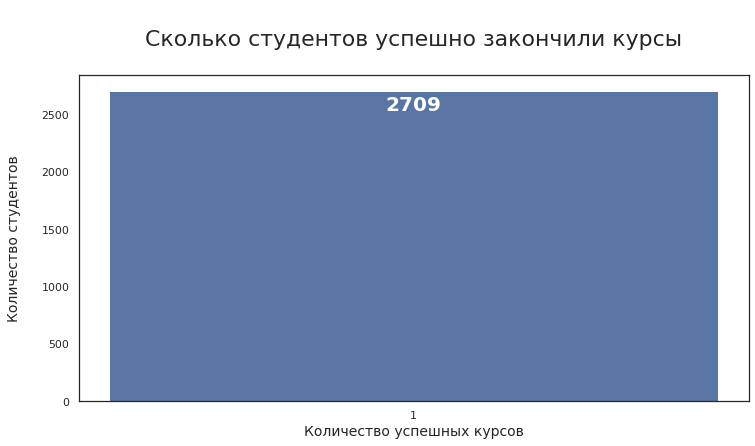

In [56]:
sns.set(rc={'figure.figsize':(12,6)}, style="white")
# строим график
splot = sns.barplot(data=exam_successful_students_summary, x='exams_count', y='students_count')
# подписываем бары на графике
for g in splot.patches:    
    splot.annotate(format(g.get_height(), '.0f'), 
        (g.get_x() + g.get_width() / 2., g.get_height()),                   
        ha = 'center', va = 'center',                   
        xytext = (0, -14),                   
        textcoords = 'offset points',
        color = 'white',
        fontweight = 'bold',
        fontsize = 20)
# подписываем сам график и оси
plt.title('\nСколько студентов успешно закончили курсы\n', fontsize = 22)
plt.xlabel("Количество успешных курсов", size = 14)
plt.ylabel("Количество студентов\n", size = 14)
plt.show()

### ОТВЕТ: 2709

### ВЫВОДЫ: 
Не смотря на то, что у нас большое количество курсов (22) и данные за 4 семестра, очень маленькое количество студентов успешно завершило только 1 курс, и нет студентов, которые успешно завершили 2 и более курсов.

***

### 2. Выяви самый сложный и самый простой экзамен: 
найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (5 баллов)

*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

### Расчеты

результирующий датафрейм с результатами оценок студентов, где тип теста Экзамен

In [57]:
# объединяем таблицы по id экзамена
assessments_exam = studentAssessment_df.merge(assessments_df.query('assessment_type == "Exam"'), on='id_assessment')

assessments_exam.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0


группируем по курсу (предмет, семестр) и id экзамена и считаем количество студентов, которые сдавали этот экзамен

In [58]:
# группируем по курсу (предмет, семестр) и id экзамена и считаем количество студентов, которые сдавали этот экзамен
# сохраняем в отдельный датафрейм
assessments_exam_students_count = assessments_exam \
    .groupby(['code_module', 'code_presentation', 'id_assessment'], as_index = False) \
    .agg({'id_student':'count'}) \
    .rename(columns={'id_student':'exams_count'})

assessments_exam_students_count.shape

(6, 4)

отбираем в отдельный датафрейм только успешные сдачи экзамена score >= 40 и не перезачет is_banked == 0

In [59]:
# отбираем успешные сдачи экзамена score >= 40 и не перезачет is_banked == 0
assessments_exam_successful = assessments_exam.query('score >= 40 & is_banked == 0')

assessments_exam_successful.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0
5,24290,560494,230,0,92.0,CCC,2014B,Exam,NaN,100.0


группируем по курсу (предмет, семестр) и id экзамена и считаем количество студентов, которые УСПЕШНО сдали этот экзамен

In [60]:
# группируем по курсу (предмет, семестр) и id экзамена и считаем количество студентов, которые успешно сдали этот экзамен
# сохраняем в отдельный датафрейм
assessments_exam_successful_students_count = assessments_exam_successful \
    .groupby(['code_module', 'code_presentation', 'id_assessment'], as_index = False) \
    .agg({'id_student':'count'}) \
    .rename(columns={'id_student':'successful_exams_count'})

assessments_exam_successful_students_count.head()

,code_module,code_presentation,id_assessment,successful_exams_count
0,CCC,2014B,24290,664
1,CCC,2014J,24299,1019
2,DDD,2013B,25340,504
3,DDD,2013J,25354,878
4,DDD,2014B,25361,485


объединияем датафреймы со всеми экзаменами и успешными экзаменами

In [61]:
# объединияем датафреймы по курсу (предмет, семестр) и id экзамена
courses_exams = assessments_exam_students_count \
    .merge(assessments_exam_successful_students_count, on = ['code_module', 'code_presentation', 'id_assessment'])
courses_exams.head()

,code_module,code_presentation,id_assessment,exams_count,successful_exams_count
0,CCC,2014B,24290,747,664
1,CCC,2014J,24299,1168,1019
2,DDD,2013B,25340,602,504
3,DDD,2013J,25354,968,878
4,DDD,2014B,25361,524,485


считаем завершаемость

In [62]:
# считаем завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен
courses_exams['exam_score'] = (courses_exams['successful_exams_count'] /  courses_exams['exams_count'] * 100).round(2)

# отсортируем exam_score по возрастанию
courses_exams = courses_exams.sort_values('exam_score', ascending = True)
courses_exams.head()

,code_module,code_presentation,id_assessment,exams_count,successful_exams_count,exam_score
2,DDD,2013B,25340,602,504,83.72
1,CCC,2014J,24299,1168,1019,87.24
5,DDD,2014J,25368,950,842,88.63
0,CCC,2014B,24290,747,664,88.89
3,DDD,2013J,25354,968,878,90.70


для отображения наименования курса на графике создадим дополнительное поле с полным наименованием курса

In [63]:
# дополнительное поле с полным наименованием курса
courses_exams['course_name'] = courses_exams['code_module'] + '_' + courses_exams['code_presentation']

рисуем график

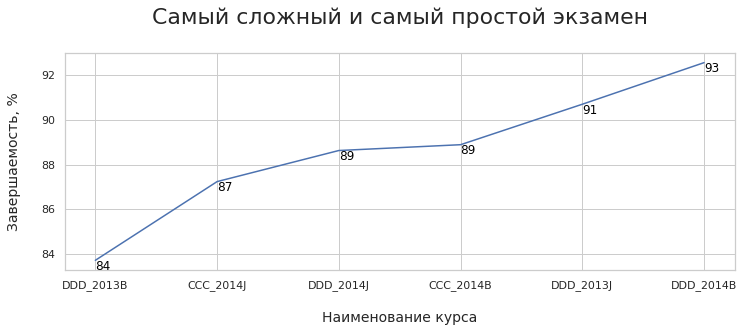

In [64]:
sns.set(rc={'figure.figsize':(12,4)}, style="whitegrid")
# рисуем график
splot = sns.lineplot(data=courses_exams, x='course_name', y='exam_score')
# подписываем точки на графике
for x, y in zip(courses_exams['course_name'], courses_exams['exam_score']):
    plt.text(x = x,
    y = y-0.43,
    s = '{:.0f}'.format(y),
    color = 'black')
# подписываем сам график и оси
plt.title('Самый сложный и самый простой экзамен\n', fontsize = 22)
plt.xlabel("\nНаименование курса", size = 14)
plt.ylabel("Завершаемость, %\n", size = 14)
plt.show()

### ОТВЕТ:

**Самый сложный:** экзамен на курсе DDD в семестре 2013B 84% завершаемость

**Самый простой:** экзамен на курсе DDD в семестре 2014B 93% завершаемость

### ВЫВОДЫ:
Из предобработки помним, что количество тестов в этих двух курсах разное:
- DDD в семестре 2013B:	CMA-7	Exam-1	TMA-6
- DDD в семестре 2014B:	CMA-0	Exam-1	TMA-6

Получается, что на курсе, где не было промежуточных тестов с компьютерной оценкой, сдать экзамен оказался проще. 

Возможно в семестре 2013B была более сложная программа курса с более сложным экзаменом, поэтому предусмотрели промежуточные тесты с компьютерной оценкой, чтобы студенты лучше усвоили материал. А потом программу упростили и не стали делать промежуточных тестов с компьютерной оценкой, потому что экзамен достаточно простой.

***

### 3. По каждому предмету определи средний срок сдачи экзаменов 
(под сдачей понимаем последнее успешное прохождение экзамена студентом). (5 баллов) 

Как мы помним курс у нас состоит из одного предмета в семестра. Предмет с одинаковым именем, но в разных семестрах будем считать разными курсами. Поэтому считать средний срок сдачи экзаменов будем в разрезе курсов, тем более что у нас есть курсы, где предусмотрено несколько экзаменов.

### Расчеты

результирующий датафрейм с результатами оценок студентов, где тип теста Экзамен

In [65]:
# объединяем таблицы по id Экзамена
assessments_exam = studentAssessment_df.merge(assessments_df.query('assessment_type == "Exam"'), on='id_assessment')
assessments_exam.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0


отбираем в отдельный датафрейм только успешные сдачи экзамена score >= 40 и не перезачет is_banked == 0

In [66]:
# отбираем успешные сдачи экзамена score >= 40 и не перезачет is_banked == 0
assessments_exam_successful = assessments_exam.query('score >= 40 & is_banked == 0')
assessments_exam_successful.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0
5,24290,560494,230,0,92.0,CCC,2014B,Exam,NaN,100.0


проверим есть ли у нас студенты, которые успешно сдали один и тот же экзамен (например, чтобы повысить оценку), 

чтобы взять только последнюю успешную сдачу

In [67]:
# сгруппируем id студента и id экзамена, и посчитаем количество сдач
# отсортируем результат по убыванию 
assessments_exam_successful \
    .groupby(['id_student', 'id_assessment'], as_index = False) \
    .agg({'date_submitted':'count'}) \
    .sort_values('date_submitted', ascending = False) \
    .head()

,id_student,id_assessment,date_submitted
0,23698,24299,1
2925,627933,24290,1
2931,628157,24290,1
2930,628114,24299,1
2929,628099,25361,1


все студенты сдавали успешно по 1 разу, дополнительной фильтрации данных не требуется

из courses_df подтягиваем продолжительность семестра в днях, чтобы проверить в срок сдают студенты экзамены или нет

In [68]:
# объединяем таблицы по предмету и семестру
assessments_exam_successful = assessments_exam_successful \
    .merge(courses_df, on=['code_module', 'code_presentation'])
assessments_exam_successful.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length
0,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,241
1,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,241
2,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,241
3,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,241
4,24290,560494,230,0,92.0,CCC,2014B,Exam,NaN,100.0,241


считаем среднее время сдачи

In [69]:
# группируем по курсу (предмет, семестр) и экзамену
# считаем среднее время сдачи и дедлайн 
assessments_exam_successful_dates = assessments_exam_successful\
    .groupby(['code_module', 'code_presentation','id_assessment'], as_index = False) \
    .agg({'date_submitted':'mean', 'module_presentation_length':'mean'}) \
    .rename(columns={'date_submitted':'date_exam_mean', 'module_presentation_length':'date_exam_control'})

# отсортируем результат по возрастанию 
assessments_exam_successful_dates = assessments_exam_successful_dates.sort_values('date_exam_mean', ascending = True)

assessments_exam_successful_dates.head()

,code_module,code_presentation,id_assessment,date_exam_mean,date_exam_control
2,DDD,2013B,25340,230.164683,240
0,CCC,2014B,24290,231.581325,241
4,DDD,2014B,25361,234.936082,241
3,DDD,2013J,25354,239.509112,261
5,DDD,2014J,25368,242.804038,262


итоговая таблица со средним сроком сдачи экзаменов по курсам

In [70]:
# итоговая таблица со средним сроком сдачи экзаменов по курсам
assessments_exam_successful_dates[['code_module', 'code_presentation','date_exam_mean','date_exam_control']].round(0)

,code_module,code_presentation,date_exam_mean,date_exam_control
2,DDD,2013B,230.0,240
0,CCC,2014B,232.0,241
4,DDD,2014B,235.0,241
3,DDD,2013J,240.0,261
5,DDD,2014J,243.0,262
1,CCC,2014J,244.0,269


для отображения наименования курса на графике создадим дополнительное поле с полным наименованием

In [71]:
# создадим дополнительное поле с полным наименованием
assessments_exam_successful_dates['course_name'] = assessments_exam_successful_dates['code_module'] \
    + '_' \
    + assessments_exam_successful_dates['code_presentation']

рисуем график

в среднем студенты укладываются в дэдлайн

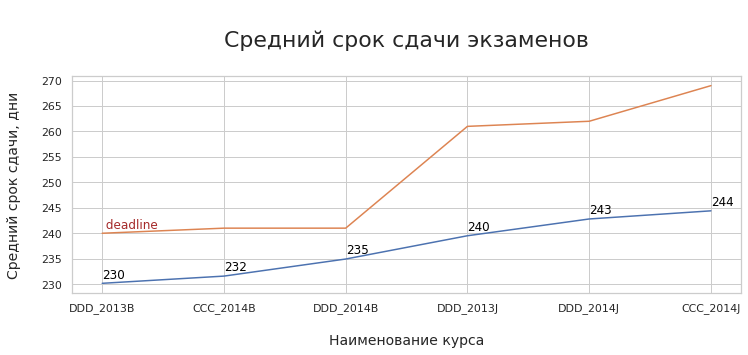

In [72]:
sns.set(rc={'figure.figsize':(12,4)}, style="whitegrid")
# рисуем график
splot = sns.lineplot(data=assessments_exam_successful_dates, x='course_name', y='date_exam_mean', markers=True)
splot1 = sns.lineplot(data=assessments_exam_successful_dates, x='course_name', y='date_exam_control', markers=True)

# подписываем точки на графике
for x, y in zip(assessments_exam_successful_dates['course_name'], 
                assessments_exam_successful_dates['date_exam_mean']):
    plt.text(x = x,
    y = y+1,
    s = '{:.0f}'.format(y),
    color = 'black')

plt.text(x = 'DDD_2013B',y = 241, s = ' deadline', color = 'brown')
# подписываем сам график и оси    
plt.title('\nСредний срок сдачи экзаменов\n', fontsize = 22)
plt.xlabel("\nНаименование курса", size = 14)
plt.ylabel("Средний срок сдачи, дни\n", size = 14)
plt.show()

### ОТВЕТ:

**Средний срок сдачи экзамена:** 

- `курс DDD в семестре 2013B` — 230 дней
- `курс CCC в семестре 2014B` — 232 дней
- `курс DDD в семестре 2014B` — 235 дней
- `курс DDD в семестре 2013J` — 240 дней
- `курс DDD в семестре 2014J` — 243 дней
- `курс CCC в семестре 2014J` — 244 дней

### ВЫВОДЫ:
Студенты в среднем укладываются в дэдлайны по сдаче экзаменов

***

### 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). (8 баллов)

Как мы помним курс у нас состоит из одного предмета в семестра. Предмет с одинаковым именем, но в разных семестрах будем считать разными курсами. Поэтому считать ТОП-3 будем в разрезе курсов.

### Расчеты

группируем по курсу и считаем количество студентов на каждом

In [73]:
# группируем по курсу и считаем количество студентов на каждом
studentRegistration_all = studentRegistration_df \
    .groupby(['code_module', 'code_presentation'], as_index = False) \
    .agg({'id_student': 'count'}) \
    .rename(columns={'id_student':'students_count'}) \
    .sort_values('students_count', ascending = False) \

для отображения наименования курса на графике создадим дополнительное поле с полным наименованием

In [74]:
# дополнительное поле с полным наименованием
studentRegistration_all['course_name'] = studentRegistration_all['code_module'] \
    + '_' \
    + studentRegistration_all['code_presentation']

топ 3 курсов по регистрации

In [75]:
# топ 3 курсов по регистрации
studentRegistration_all[['code_module','code_presentation','students_count']].head(3)

,code_module,code_presentation,students_count
7,CCC,2014J,2497
18,FFF,2014J,2365
5,BBB,2014J,2292


строим график

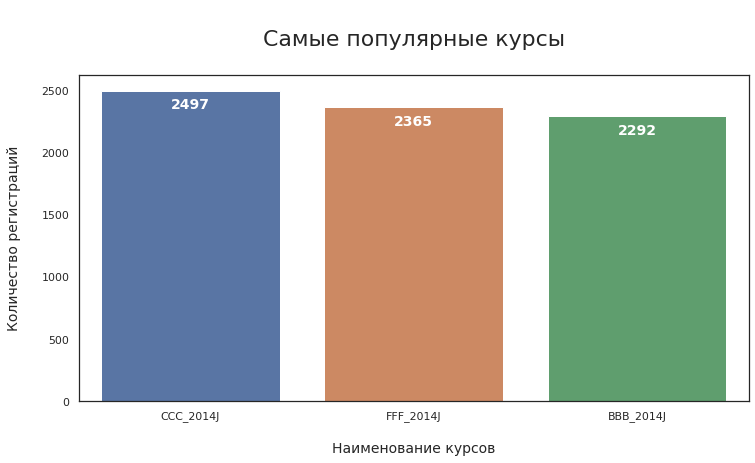

In [76]:
sns.set(rc={'figure.figsize':(12,6)}, style="white")
# строим график
splot = sns.barplot(data=studentRegistration_all.head(3), x='course_name', y='students_count')
# подписываем бары на графике
for g in splot.patches:    
    splot.annotate(format(g.get_height(), '.0f'), 
        (g.get_x() + g.get_width() / 2., g.get_height()),                   
        ha = 'center', va = 'center',                   
        xytext = (0, -14),                   
        textcoords = 'offset points',
        color = 'white',
        fontweight = 'bold',
        fontsize = 14)
# подписываем сам график и оси
plt.title('\nСамые популярные курсы\n', fontsize = 22)
plt.xlabel("\nНаименование курсов", size = 14)
plt.ylabel("Количество регистраций\n", size = 14)
plt.show()

*

### Отток
Что можно считать **оттоком**:
 - когда студент отменил регистрацию на курс до начала обучения 
 - либо в день начала обучения
 - либо до первой проверочной работы. Посмотрим минимальную дату теста в таблице assessments_df (12 дней с начала семестра)
 
**Отток** - это когда студент либо отменил регистрацию до начала обучения, либо в первые 11 дней после старта обучения

фильтруем по дате отмены (дата отмены регистрации < минимальной даты теста, подходит под все наши условия)

группируем по курсу (предмет, семестр), считаем количество студентов

In [77]:
# фильтруем по дате отмены, группируем по курсу (предмет, семестр), считаем количество студентов
# сохраняем в отдельный датафрейм

# минимальная дата теста
min_date = assessments_df['date'].min()

studentRegistration_churn = studentRegistration_df \
    .query('date_unregistration < @min_date') \
    .groupby(['code_module','code_presentation'], as_index=False) \
    .agg({'id_student':'count'}) \
    .rename(columns={'id_student':'students_churn'})

studentRegistration_churn.head()

,code_module,code_presentation,students_churn
0,AAA,2013J,9
1,AAA,2014J,14
2,BBB,2013B,151
3,BBB,2013J,374
4,BBB,2014B,313


объединяем датафреймы с общим количеством зарегистрированных студентов с количеством отменивших регистрацию

In [78]:
# объединяем датафреймы по курсам
studentRegistration_churn = \
    studentRegistration_all.merge(studentRegistration_churn, on=['code_module','code_presentation'])

studentRegistration_churn.head()

,code_module,code_presentation,students_count,course_name,students_churn
0,CCC,2014J,2497,CCC_2014J,276
1,FFF,2014J,2365,FFF_2014J,257
2,BBB,2014J,2292,BBB_2014J,301
3,FFF,2013J,2283,FFF_2013J,277
4,BBB,2013J,2237,BBB_2013J,374


считаем отток в %

количество зарегистрировавшихся / количество отменивших регистрацию

In [79]:
# считаем отток в %
# сортирум отток по убыванию
# выводим топ 3
studentRegistration_churn['churn'] = \
    studentRegistration_churn.students_churn / studentRegistration_churn.students_count * 100

studentRegistration_churn = studentRegistration_churn.sort_values('churn', ascending = False)
studentRegistration_churn.head(3)

,code_module,code_presentation,students_count,course_name,students_churn,churn
9,BBB,2014B,1613,BBB_2014B,313,19.404836
4,BBB,2013J,2237,BBB_2013J,374,16.718820
6,CCC,2014B,1936,CCC_2014B,323,16.683884


строим график

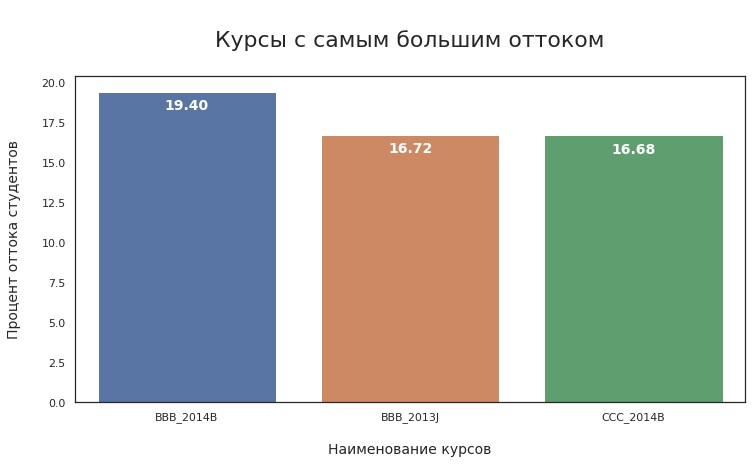

In [80]:
sns.set(rc={'figure.figsize':(12,6)}, style="white")
# строим график
splot = sns.barplot(data=studentRegistration_churn.head(3), x='course_name', y='churn')
# подписываем бары на графике
for g in splot.patches:    
    splot.annotate(format(g.get_height(), '.2f'), 
        (g.get_x() + g.get_width() / 2., g.get_height()),                   
        ha = 'center', va = 'center',                   
        xytext = (0, -14),                   
        textcoords = 'offset points',
        color = 'white',
        fontweight = 'bold',
        fontsize = 14)
# подписываем сам график и оси
plt.title('\nКурсы с самым большим оттоком\n', fontsize = 22)
plt.xlabel("\nНаименование курсов", size = 14)
plt.ylabel("Процент оттока студентов\n", size = 14)
plt.show()

#### ОТВЕТ:

**Самые популярные курсы:** 

- `курс CCC в семестре 2014J` — 2497 регистраций
- `курс FFF в семестре 2014J` — 2365 регистраций
- `курс BBB в семестре 2014J` — 2292 регистраций

**Курсы с самым большим оттоком:** 

- `курс BBB в семестре 2014B` — 19.40% оттока
- `курс BBB в семестре 2013J` — 16.72% оттока
- `курс CCC в семестре 2014B` — 16.68% оттока

#### ВЫВОДЫ:
С самых полулярных курсов не очень большой отток студентов, так как самые популярные курсы не входят в ТОП-3 курсов по оттоку.

Сам процент оттока мне не кажется драмматически высоким, в около 20% студентов максимум отменяют регистрацию до начала либо в первые дни старта курса.

***

### 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.  (10 баллов) 

Под "завершаемостью курсов" здесь будем понимать их "доходимость" - сколько процентов обучающихся прошли до конца, сдали экзамен.

**COR (Completion Rate) - доходимость**

*количество студентов сдавших экзамен по курсу / количество студентов, начаших обучение на курсе

Под "сроками сдачи курсов" будем понимать дату сдачи экзаменов по курсу. 

Нам в данном случае не так важна оценка на экзамене как сам факт, что студент доучился до момента сдачи экзамена и хоть как-то, но сдал.

### Расчеты

сначала посчитаем доходимость для каждого курса, а потом среднюю доходимость по семестрам

результирующий датафрейм с результатами оценок студентов, где тип теста Экзамен

In [81]:
# объединяем таблицы по id Экзамена
assessments_exam = studentAssessment_df.merge(assessments_df.query('assessment_type == "Exam"'), on='id_assessment')

assessments_exam.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0


сначала посчитаем доходимость для каждого курса, а потом среднюю доходимость по семестрам

из задания 1 помним, что у нас нет студентов успешно окончивших курсы CCC_2014B и CCC_2014J (для этих курсов надо 2 экзамена, чтобы курс считался успешно оконченным)

значит нам надо эти курсы убрать из результирующего датафрейма, чтоб они не влияли на расчеты

In [82]:
# убираем эти курсы результирующего датафрейма
exam_students_without_CCC = assessments_exam \
    .query('code_module != "CCC" & (code_presentation != "2014B" | code_presentation != "2014J")')

exam_students_without_CCC.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
1915,25340,45664,230,0,40.0,DDD,2013B,Exam,240.0,100.0
1916,25340,52014,231,0,13.0,DDD,2013B,Exam,240.0,100.0
1917,25340,53488,231,0,73.0,DDD,2013B,Exam,240.0,100.0
1918,25340,60135,229,0,40.0,DDD,2013B,Exam,240.0,100.0
1919,25340,67602,230,0,49.0,DDD,2013B,Exam,240.0,100.0


теперь считаем количество студентов, закончивших курсы, и среднее время сдачи экзамена = завершения курса

In [83]:
# группируем по курсу (предмет,семестр)
# считаем количество сдавших студентов и среднее время сдачи экзамена
# сохраняем в отдельный датафрейм
completed_courses = exam_students_without_CCC \
    .groupby(['code_module','code_presentation'], as_index = False) \
    .agg({'id_student': 'count', 'date_submitted':'mean'}) \
    .rename(columns={'id_student':'students_finished', 'date_submitted':'date_completed_mean'}) 

completed_courses.head()

,code_module,code_presentation,students_finished,date_completed_mean
0,DDD,2013B,602,230.179402
1,DDD,2013J,968,239.505165
2,DDD,2014B,524,234.944656
3,DDD,2014J,950,242.791579


для каждого курса считаем количество студентов, которые начали обучение 

In [84]:
# дата отмены регистрации > минимальной даты сдачи теста или пустая, 
# то есть студент отменил регистрацию во время обучения, или дошел до конца
# по таким условиям остаются только те студенты, которые начали обучение
# группируем по курсу (предмет,семестр) и считаем количество студентов, которые начали обучение 
# сохраняем в отдельный датафрейм

min_date = assessments_df['date'].min()

started_courses = studentRegistration_df \
    .query('date_unregistration >= @min_date | date_unregistration != date_unregistration') \
    .groupby(['code_module','code_presentation'], as_index = False) \
    .agg({'id_student': 'count'}) \
    .rename(columns={'id_student':'students_started'}) \
    .sort_values('students_started', ascending = False)

started_courses.head()

,code_module,code_presentation,students_started
7,CCC,2014J,2221
18,FFF,2014J,2108
16,FFF,2013J,2006
5,BBB,2014J,1991
3,BBB,2013J,1863


объединяем датафреймы со студентами, начавшими обучение, со студентами успешно завершившими обучение

In [85]:
# объединяем датафреймы по семестру
# how='left', чтобы гарантированно оставить все курсы, по которым было начато обученик
courses_by_semester = started_courses.merge(completed_courses, on = ['code_module', 'code_presentation'], how='left')

courses_by_semester.head()

,code_module,code_presentation,students_started,students_finished,date_completed_mean
0,CCC,2014J,2221,NaN,NaN
1,FFF,2014J,2108,NaN,NaN
2,FFF,2013J,2006,NaN,NaN
3,BBB,2014J,1991,NaN,NaN
4,BBB,2013J,1863,NaN,NaN


заполняем пустые значения в поле students_finished, чтоб корректно посчитать доходимость
поле date_completed_mean оставим как есть, чтоб не уменьшать значение среднего, когда будем считать данные для семестра

In [86]:
# заполняем пустые значения в поле students_finished нулями
courses_by_semester['students_finished'] = courses_by_semester['students_finished'].fillna(0)

courses_by_semester.head()

,code_module,code_presentation,students_started,students_finished,date_completed_mean
0,CCC,2014J,2221,0.0,NaN
1,FFF,2014J,2108,0.0,NaN
2,FFF,2013J,2006,0.0,NaN
3,BBB,2014J,1991,0.0,NaN
4,BBB,2013J,1863,0.0,NaN


считаем доходимость в %

In [87]:
# считаем COR
courses_by_semester['COR'] = courses_by_semester['students_finished'] / courses_by_semester['students_started'] * 100

courses_by_semester.head()

,code_module,code_presentation,students_started,students_finished,date_completed_mean,COR
0,CCC,2014J,2221,0.0,NaN,0.0
1,FFF,2014J,2108,0.0,NaN,0.0
2,FFF,2013J,2006,0.0,NaN,0.0
3,BBB,2014J,1991,0.0,NaN,0.0
4,BBB,2013J,1863,0.0,NaN,0.0


группируем, чтобы посчитать значения для семестров

In [88]:
# группируем по семестрам, считаем среднюю доходимость и среднюю дату завершения
semesters = courses_by_semester \
    .groupby('code_presentation', as_index=False) \
    .agg({'COR': 'mean', 'date_completed_mean': 'mean'})

semesters.head()

,code_presentation,COR,date_completed_mean
0,2013B,16.722222,230.179402
1,2013J,9.569000,239.505165
2,2014B,8.254568,234.944656
3,2014J,8.535490,242.791579


строим график

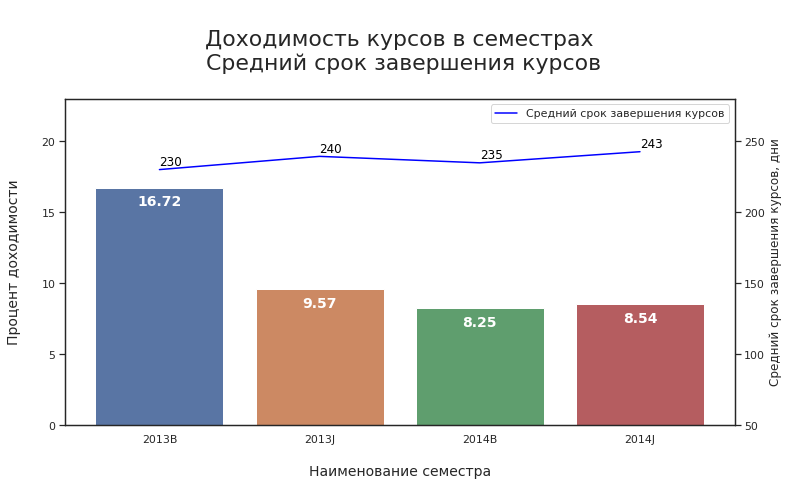

In [89]:
sns.set(rc={'figure.figsize':(12,6)}, style="white")
# строим график
splot = sns.barplot(data=semesters, x='code_presentation', y='COR')
# подписываем бары на графике
for g in splot.patches:    
    splot.annotate(format(g.get_height(), '.2f'), 
        (g.get_x() + g.get_width() / 2., g.get_height()),                   
        ha = 'center', va = 'center',                   
        xytext = (0, -14),                   
        textcoords = 'offset points',
        color = 'white',
        fontweight = 'bold',
        fontsize = 14)
splot.set_ylabel('Процент доходимости\n', size = 14)
splot.set_xlabel('\nНаименование семестра', size = 14)
splot.set_ylim(0, 23)

# set up the 2nd axis
splot1 = splot.twinx()    
# plot line graph on axis #1
sns.lineplot(data=semesters, x='code_presentation', y='date_completed_mean', 
             color='blue', ax = splot1)
# подписываем точки на графике
for x, y in zip(semesters['code_presentation'], 
                semesters['date_completed_mean']):
    plt.text(x = x,
    y = y + 3,
    s = '{:.0f}'.format(y),
    color = 'black')

splot1.set_ylabel('Средний срок завершения курсов, дни')
splot1.set_ylim(50, 280)
splot1.legend(['Средний срок завершения курсов'], loc="upper right")

# подписываем сам график и оси
plt.title('\nДоходимость курсов в семестрах\n Средний срок завершения курсов\n', fontsize = 22)
plt.show()

#### ОТВЕТ:

**Семестр с самой низкой доходимостью курсов:** `2014B` — 8.25% доходимость

**Семестр с самым долгими средними сроками завершения курсов:** `2014J` — 243 дня

#### ВЫВОДЫ:
У нас очень низкая доходимость курсов, доходимость в 2014ом году снизилась практически в 2 раза от максимального значения в 2013ом, что-то изменилось в программах курсов или в организации учебного процесса, что так сильно повлияло на доходимость.

***

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 
В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Описание подхода можно найти тут. (35 баллов)

Предлагаемый Василием вариант сегментирования студентов:

- R - среднее время сдачи одного экзамена, 
- F - завершаемость курсов, 
- M - среднее количество баллов, получаемое за экзамен

Не согласна с такими метриками. Для описания студентов чаще всего используют такие описательные метрики как: трудолюбие и способности.

К трудолюбию можно отнести: 
- дисциплинированность - как вообще студент учится в течении курса
- целеустремленность - как хорошо студент достигает поставленных целей (с разрезе обучения: насколько часто завершает начатые курсы)

К способностям:
- средний балл за все оцениваемые работы в течении курса. По всем видам проверочных тестов, а не только экзаменов.

**Таким образом, буду использовать следующий вариант сегментирования студентов**:

- R - дисциплинированность - сколько тестовых работ студент сдал / сколько предусматривается программой курса (среднее по всем курсам). Без оценивания на сколько баллов сданы тесты, важно что студент сдавал тесты, а баллы будем смотреть в метрике M - способности
- F - доходимость - сколько курсов закончено / сколько курсов начато. Без оценивания на сколько баллов сдан экзамен, важно что студент дошел до конца обучения, а баллы будем смотреть в метрике M - способности 
- M - способности - среднее количество баллов, получаемое за тесты во время обучения (все виды тестов)

### Расчеты

делаем сводную таблицу с полными данными по тестам, чтобы по каждой сдаче студента какой-либо работы видеть курс, тип теста

In [90]:
# объединяем таблицы studentAssessment_df и assessments_df по id_assessment
# сохраняем в отдельный датафрейм
studentAssessment_df_full = studentAssessment_df \
    .merge(assessments_df, on='id_assessment')

studentAssessment_df_full.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0


In [91]:
# проверяем, что никакие сдачи не потерялись. Размер таблицы studentAssessment_df (173912, 5)
studentAssessment_df_full.shape

(173912, 10)

нам нужны данные по текущим студентам и их сдачам, поэтому убираем перезачеты

In [92]:
# оставляем только не перезачеты
studentAssessment_df_full = studentAssessment_df_full.query('is_banked == 0')

из предобработки помним, что у нас есть непроверенные работы, где score = NaN

как факт сдачи работы студентом они нам нужны, оставляем их для расчетов, но не заполняем 0, чтобы они не портили средний балл

In [93]:
# непроверенные работы
studentAssessment_df_full.query('score != score')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
215,1752,721259,22,0,NaN,AAA,2013J,TMA,19.0,10.0
937,1754,260355,127,0,NaN,AAA,2013J,TMA,117.0,20.0
2364,1760,2606802,180,0,NaN,AAA,2014J,TMA,117.0,20.0
3358,14984,186780,77,0,NaN,BBB,2013B,TMA,19.0,5.0
3914,14984,531205,26,0,NaN,BBB,2013B,TMA,19.0,5.0
...,...,...,...,...,...,...,...,...,...,...
148929,34903,582670,241,0,NaN,FFF,2014J,TMA,199.0,25.0
159251,37415,610738,87,0,NaN,GGG,2013J,TMA,61.0,0.0
166390,37427,631786,221,0,NaN,GGG,2014B,TMA,166.0,0.0
169725,37435,648110,62,0,NaN,GGG,2014J,TMA,61.0,0.0


вычисляем, сколько раз студент сдавал каждый экзамен

каждый студент сдавал каждый экзамен только 1 раз

In [94]:
# группируем id студента и id теста, считаем количество сданных тестов
studentAssessment_df_full \
    .groupby(['id_student','id_assessment'], as_index = False) \
    .agg({'date_submitted':'count'}) \
    .sort_values('date_submitted', ascending = False)\
    .head()

,id_student,id_assessment,date_submitted
0,6516,1758,1
114662,620694,15016,1
114664,620694,15018,1
114665,620694,15019,1
114666,620698,15020,1


по каждому курсу (у нас на курсе может быть несколько экзаменов) считаем количество сданных экзаменов, средний балл

In [95]:
# отбираем только экзамены, группируем по курсу (предмет, семестр) и студенту, 
# считаем количество сданных экзаменов, средний балл
student_exams = studentAssessment_df_full.query('assessment_type == "Exam"') \
    .groupby(['code_module','code_presentation','id_student'], as_index = False) \
    .agg({'id_assessment':'count', 'score':'mean'}) \
    .rename(columns={'id_assessment':'exam_passed', 'score':'score_exam_mean'})

student_exams.head()

,code_module,code_presentation,id_student,exam_passed,score_exam_mean
0,CCC,2014B,29764,1,94.0
1,CCC,2014B,29820,1,76.0
2,CCC,2014B,40604,1,66.0
3,CCC,2014B,42638,1,50.0
4,CCC,2014B,46605,1,98.0


по каждому курсу (у нас на курсе может быть несколько тестов) считаем количество сданных тестов, средний балл

In [96]:
# отбираем только экзамены, группируем по курсу (предмет, семестр) и студенту, 
# считаем количество сданных экзаменов, средний балл
student_tests = studentAssessment_df_full.query('assessment_type != "Exam"') \
    .groupby(['code_module','code_presentation','id_student'], as_index = False) \
    .agg({'id_assessment':'count', 'score':'mean'}) \
    .rename(columns={'id_assessment':'test_passed', 'score':'score_test_mean'})

student_tests.head()

,code_module,code_presentation,id_student,test_passed,score_test_mean
0,AAA,2013J,11391,5,82.0
1,AAA,2013J,28400,5,66.4
2,AAA,2013J,31604,5,76.0
3,AAA,2013J,32885,5,54.4
4,AAA,2013J,38053,5,68.0


считаем количество экзаменов для каждого курса

In [97]:
# отбираем только экзамены, группируем по курсу (предмент, семестр), считаем количество
# сохраняем в отдельный датафрейм
exam_total_count = assessments_df.query('assessment_type == "Exam"') \
    .groupby(['code_module','code_presentation'], as_index=False) \
    .agg({'id_assessment':'count'}) \
    .rename(columns={'id_assessment':'exam_total_count'})

exam_total_count.head()

,code_module,code_presentation,exam_total_count
0,AAA,2013J,1
1,AAA,2014J,1
2,BBB,2013B,1
3,BBB,2013J,1
4,BBB,2014B,1


считаем количество промежуточных тестов для каждого курса

In [98]:
# отбираем только промежуточные тесты, группируем по курсу (предмент, семестр), считаем количество
# сохраняем в отдельный датафрейм
test_total_count = assessments_df.query('assessment_type != "Exam"') \
    .groupby(['code_module','code_presentation'], as_index=False) \
    .agg({'id_assessment':'count'}) \
    .rename(columns={'id_assessment':'test_total_count'})

test_total_count.head()

,code_module,code_presentation,test_total_count
0,AAA,2013J,5
1,AAA,2014J,5
2,BBB,2013B,11
3,BBB,2013J,11
4,BBB,2014B,11


рассматривваем студентов которые как минимум начали обучение на курсах. Потому что если не начали то и метрики будут нулевыми

In [99]:
# дата отмены регистрации > минимальной даты сдачи теста или пустая, 
# то есть студент отменил регистрацию во время обучения, или дошел до конца
# по таким условиям остаются только те студенты, которые начали обучение
# сохраняем в отдельный датафрейм

min_date = assessments_df['date'].min()

students_courses_started = studentRegistration_df \
    .query('date_unregistration >= @min_date | date_unregistration != date_unregistration')

# считаем сколько уникальных студентов начали обучение, понадобится нам для самопроверки
students_courses_started['id_student'].nunique()

25920

к студентам, которые начали обучение, добавляем данные по экзаменам, по тестам

In [100]:
# к студентам, которые начали обучение, добавляем данные по экзаменам, если они их сдавали
students = students_courses_started \
    .merge(student_exams, \
           on=['code_module','code_presentation','id_student'], how = 'left') \
    .merge(student_tests, \
           on=['code_module','code_presentation','id_student'], how = 'left') \
    .merge(exam_total_count, \
           on=['code_module','code_presentation']) \
    .merge(test_total_count, \
           on=['code_module','code_presentation'])

students.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,exam_passed,score_exam_mean,test_passed,score_test_mean,exam_total_count,test_total_count
0,AAA,2013J,11391,-159.0,NaN,NaN,NaN,5.0,82.0,1,5
1,AAA,2013J,28400,-53.0,NaN,NaN,NaN,5.0,66.4,1,5
2,AAA,2013J,30268,-92.0,12.0,NaN,NaN,NaN,NaN,1,5
3,AAA,2013J,31604,-52.0,NaN,NaN,NaN,5.0,76.0,1,5
4,AAA,2013J,32885,-176.0,NaN,NaN,NaN,5.0,54.4,1,5


проверяем, что никого из начавших обучение не потеряли

In [101]:
# проверяем, что никого из начавших обучение не потеряли
students['id_student'].nunique()

25920

для подсчета количества курсов создадим дополнительное поле с полным наименованием курса

In [102]:
# для подсчета количества курсов создадим дополнительное поле с полным наименованием курса
students['course_name'] = students['code_module'] + '_' + students['code_presentation']
students.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,exam_passed,score_exam_mean,test_passed,score_test_mean,exam_total_count,test_total_count,course_name
0,AAA,2013J,11391,-159.0,NaN,NaN,NaN,5.0,82.0,1,5,AAA_2013J
1,AAA,2013J,28400,-53.0,NaN,NaN,NaN,5.0,66.4,1,5,AAA_2013J
2,AAA,2013J,30268,-92.0,12.0,NaN,NaN,NaN,NaN,1,5,AAA_2013J
3,AAA,2013J,31604,-52.0,NaN,NaN,NaN,5.0,76.0,1,5,AAA_2013J
4,AAA,2013J,32885,-176.0,NaN,NaN,NaN,5.0,54.4,1,5,AAA_2013J


заполняем пустые значения, чтобы расчеты были верными

In [103]:
# заполняем пустые значения
students['test_passed'] = students['test_passed'].fillna(0)
students['exam_passed'] = students['exam_passed'].fillna(0)


students.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,exam_passed,score_exam_mean,test_passed,score_test_mean,exam_total_count,test_total_count,course_name
0,AAA,2013J,11391,-159.0,NaN,0.0,NaN,5.0,82.0,1,5,AAA_2013J
1,AAA,2013J,28400,-53.0,NaN,0.0,NaN,5.0,66.4,1,5,AAA_2013J
2,AAA,2013J,30268,-92.0,12.0,0.0,NaN,0.0,NaN,1,5,AAA_2013J
3,AAA,2013J,31604,-52.0,NaN,0.0,NaN,5.0,76.0,1,5,AAA_2013J
4,AAA,2013J,32885,-176.0,NaN,0.0,NaN,5.0,54.4,1,5,AAA_2013J


для проверки закончил ли студент курс создадим функцию

если количество сданных экзаменов больше или равно количеству экзаменов, предусмотренных программой курса, то курс считаем завершенным 

In [104]:
def get_course_passed(row):
    exam_passed = row['exam_passed']
    exam_total_count = row['exam_total_count']
    if exam_passed >= exam_total_count:
        return 1
    else:
        return 0

In [105]:
# создаем новое поле, куда записываем завершил студент данный курс или нет
students['course_passed'] = students.apply(get_course_passed, axis=1)
students.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,exam_passed,score_exam_mean,test_passed,score_test_mean,exam_total_count,test_total_count,course_name,course_passed
0,AAA,2013J,11391,-159.0,NaN,0.0,NaN,5.0,82.0,1,5,AAA_2013J,0
1,AAA,2013J,28400,-53.0,NaN,0.0,NaN,5.0,66.4,1,5,AAA_2013J,0
2,AAA,2013J,30268,-92.0,12.0,0.0,NaN,0.0,NaN,1,5,AAA_2013J,0
3,AAA,2013J,31604,-52.0,NaN,0.0,NaN,5.0,76.0,1,5,AAA_2013J,0
4,AAA,2013J,32885,-176.0,NaN,0.0,NaN,5.0,54.4,1,5,AAA_2013J,0


считаем метрики для каждого студента

In [106]:
# группируем по студентам, 
# считаем количество начатых курсов, средний балл за тесты и за экзамены, 
# количество экзаменов и тестов, которые студент сдавал, и количество по программе курса
students_summary = students \
    .groupby('id_student', as_index = False) \
    .agg({'course_name':'count', 'course_passed':'sum', \
          'score_exam_mean': 'mean', 'exam_passed':'sum', 'exam_total_count':'sum', \
          'score_test_mean': 'mean', 'test_passed':'sum', 'test_total_count':'sum'}) \
    .rename(columns={'course_name':'course_total_count'}) 
students_summary.head()

,id_student,course_total_count,course_passed,score_exam_mean,exam_passed,exam_total_count,score_test_mean,test_passed,test_total_count
0,6516,1,0,NaN,0.0,1,61.800000,5.0,5
1,8462,2,0,NaN,0.0,2,87.666667,3.0,12
2,11391,1,0,NaN,0.0,1,82.000000,5.0,5
3,23629,1,0,NaN,0.0,1,82.500000,4.0,11
4,23698,1,0,80.0,1.0,2,73.750000,8.0,8


In [107]:
# никого не потеряли
students_summary.shape

(25920, 9)

R - дисциплинированность - сколько тестовых работ студент сдал / сколько предусматривается программами курсов 

In [108]:
# R - дисциплинированность - сколько тестовых работ студент сдал / сколько предусматривается программами курсов 
students_summary['Recency'] = (students_summary['test_passed'] / students_summary['test_total_count']) 
students_summary.head()

,id_student,course_total_count,course_passed,score_exam_mean,exam_passed,exam_total_count,score_test_mean,test_passed,test_total_count,Recency
0,6516,1,0,NaN,0.0,1,61.800000,5.0,5,1.000000
1,8462,2,0,NaN,0.0,2,87.666667,3.0,12,0.250000
2,11391,1,0,NaN,0.0,1,82.000000,5.0,5,1.000000
3,23629,1,0,NaN,0.0,1,82.500000,4.0,11,0.363636
4,23698,1,0,80.0,1.0,2,73.750000,8.0,8,1.000000


In [109]:
students_summary['Recency'].value_counts()

1.000000    11852
0.000000     2660
0.500000      856
0.166667      833
0.909091      713
            ...  
0.937500        1
0.791667        1
0.590909        1
0.423077        1
0.941176        1
Name: Recency, Length: 158, dtype: int64

F - доходимость курсов -  сколько курсов закончено / сколько курсов начато

In [110]:
# F - доходимость курсов -  сколько курсов закончено / сколько курсов начато
students_summary['Frequency'] = (students_summary['course_passed'] / students_summary['course_total_count']) 
students_summary.head()

,id_student,course_total_count,course_passed,score_exam_mean,exam_passed,exam_total_count,score_test_mean,test_passed,test_total_count,Recency,Frequency
0,6516,1,0,NaN,0.0,1,61.800000,5.0,5,1.000000,0.0
1,8462,2,0,NaN,0.0,2,87.666667,3.0,12,0.250000,0.0
2,11391,1,0,NaN,0.0,1,82.000000,5.0,5,1.000000,0.0
3,23629,1,0,NaN,0.0,1,82.500000,4.0,11,0.363636,0.0
4,23698,1,0,80.0,1.0,2,73.750000,8.0,8,1.000000,0.0


In [111]:
students_summary['Frequency'].value_counts()

0.000000    22880
1.000000     2446
0.500000      561
0.333333       32
0.250000        1
Name: Frequency, dtype: int64

заполняем пустые значения в полях, чтобы посчитать среднее

In [112]:
# заполняем пустые значения
students_summary['score_exam_mean'] = students_summary['score_exam_mean'].fillna(0)
students_summary['score_test_mean'] = students_summary['score_test_mean'].fillna(0)

функция считает среднее значение оценок за экзамены и тесты, если за экзамен средней оценки нет, то берем среднюю оценку за тесты

In [113]:
def get_Monetary(row):
    exam = row['score_exam_mean']
    test = row['score_test_mean']
    if exam > 0:
        return (exam + test) / 2
    else:
        return test

In [114]:
# M - среднее количество баллов, получаемое за тесты во время обучения (все виды тестов)
students_summary['Monetary'] = students_summary.apply(get_Monetary, axis=1)
students_summary.head()

,id_student,course_total_count,course_passed,score_exam_mean,exam_passed,exam_total_count,score_test_mean,test_passed,test_total_count,Recency,Frequency,Monetary
0,6516,1,0,0.0,0.0,1,61.800000,5.0,5,1.000000,0.0,61.800000
1,8462,2,0,0.0,0.0,2,87.666667,3.0,12,0.250000,0.0,87.666667
2,11391,1,0,0.0,0.0,1,82.000000,5.0,5,1.000000,0.0,82.000000
3,23629,1,0,0.0,0.0,1,82.500000,4.0,11,0.363636,0.0,82.500000
4,23698,1,0,80.0,1.0,2,73.750000,8.0,8,1.000000,0.0,76.875000


копируем в новый датафрейм только нужные нам столбцы

In [115]:
# копируем в новый датафрейм только нужные нам столбцы
students_rfm = students_summary[['id_student','Recency', 'Frequency', 'Monetary']].copy()
students_rfm.head()

,id_student,Recency,Frequency,Monetary
0,6516,1.000000,0.0,61.800000
1,8462,0.250000,0.0,87.666667
2,11391,1.000000,0.0,82.000000
3,23629,0.363636,0.0,82.500000
4,23698,1.000000,0.0,76.875000


разбиваем значения на 3 группы

In [116]:
#  разбиваем значения на 3 группы quantile([0.33, 0.66])
quantiles = students_rfm[['Recency', 'Frequency', 'Monetary']].quantile([0.33, 0.66]).to_dict()
quantiles

{'Recency': {0.33: 0.5, 0.66: 1.0},
 'Frequency': {0.33: 0.0, 0.66: 0.0},
 'Monetary': {0.33: 63.7334090909091, 0.66: 79.5}}

функция для присвоения значений сегментов

 **дисциплинированность (recency):**
- 1 — не сдал ни одного промежуточного теста
- 2 — сдал несколько, но не все
- 3 — сдал все промежуточные тесты

**доходимость (frequency):**
- 1 — не завершил ни один начатый курс
- 2 — завершил несколько, но не все
- 3 — завершил все начатые курсы

**Среднее количество баллов (monetary):**
- 1 — невысокие баллы
- 2 — средние баллы
- 3 — высокие баллы

In [117]:
def r_score(x):
    if x < 0.5: # сдали < 50% тестов
        return 1
    elif x < 1: # сдали < 100% тестов
        return 2
    else:
        return 3 # сдали все тесты

def f_score(x):
    if x == 0: # не завершили ни один курс
        return 1
    elif x < 1: # завершили несколько, но не все
        return 2
    else:
        return 3 # завершили все курсы

def m_score(x):
    if x <= quantiles['Monetary'][.33]:
        return 1
    elif x <= quantiles['Monetary'][.66]:
        return 2
    else:
        return 3

считаем R,F,M

In [118]:
# считаем R,F,M
students_rfm['R'] = students_rfm['Recency'].apply(lambda x: r_score(x))
students_rfm['F'] = students_rfm['Frequency'].apply(lambda x: f_score(x))
students_rfm['M'] = students_rfm['Monetary'].apply(lambda x: m_score(x))

смотрим как по количеству студентов распределились значения для наших метрик

In [119]:
# смотрим как по количеству студентов распределились значения
students_rfm.groupby('R')['Recency'].agg(['mean','count'])

,mean,count
R,,
1,0.159014,8270
2,0.743991,5798
3,1.000000,11852


In [120]:
# смотрим как по количеству студентов распределились значения
students_rfm.groupby('F')['Frequency'].agg(['mean','count'])

,mean,count
F,,
1,0.0000,22880
2,0.4906,594
3,1.0000,2446


In [121]:
# смотрим как по количеству студентов распределились значения
students_rfm.groupby('M')['Monetary'].agg(['mean','count'])

,mean,count
M,,
1,34.637667,8554
2,72.390119,8589
3,86.728009,8777


считаем RFM_Score

In [122]:
# считаем RFM_Score
students_rfm['RFM_Score'] = students_rfm['R'].map(str) + students_rfm['F'].map(str) + students_rfm['M'].map(str)
students_rfm.head()

,id_student,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,6516,1.000000,0.0,61.800000,3,1,1,311
1,8462,0.250000,0.0,87.666667,1,1,3,113
2,11391,1.000000,0.0,82.000000,3,1,3,313
3,23629,0.363636,0.0,82.500000,1,1,3,113
4,23698,1.000000,0.0,76.875000,3,1,2,312


считаем количество сегментов

In [123]:
students_rfm['RFM_Score'].nunique()

26

### Описание сегментов

Мне понравилось описание типов студентов от преподавателя АлтГУ Людмила Комиссарова вот из этой статьи

https://rekportal.ru/persons/8-tipov-studentov-ot-zvezdy-do-edinorozhki/

Решила воспользоваться им, в стастье как раз используются такие описательных характеристики студентов как: способности, трудолюбие, мотивация и самооценка.

| Сегмент | Характеристика | Краткое название | Описание | 
| --- | --- | --- | --- | 
| **Низкая дисциплина** |  |  |  | 
| 111 | троечник с низкой дисциплиной и мотивацией | Потребитель | Неизвестные способности. Высокие амбиции. Отсутствие трудолюбия. Неадекватно высокая самооценка. |
| 112 | хорошист с низкой дисциплиной и мотивацией | Талантливый лентяй | Блестящие способности в потенциале. Кривая мотивация. Импульсивная трудоспособность. Прыгающая самооценка. Заядлый прокрастинатор. |
| 113 | отличник с низкой дисциплиной и мотивацией | Талантливый лентяй | Блестящие способности в потенциале. Кривая мотивация. Импульсивная трудоспособность. Прыгающая самооценка. Заядлый прокрастинатор. |
| 121 | троечник с низкой дисциплиной и средней мотивацией | Талантливый лентяй | Блестящие способности в потенциале. Кривая мотивация. Импульсивная трудоспособность. Прыгающая самооценка. Заядлый прокрастинатор. |
| 122 | хорошист с низкой дисциплиной и средней мотивацией | Маркетолог | Средние или низкие способности. Высокие или средние амбиции. Нормальное или низкое трудолюбие. Адекватная самооценка. |
| 123 | отличник с низкой дисциплиной и средней мотивацией | Принц/принцесса | Высокие или средние способности. Высокие амбиции. Низкое трудолюбие. Высокая самооценка. | 
| 131 | троечник с низкой дисциплиной и высокой мотивацией | Крутышка | Низкие способности. Огромные амбиции. Высокое трудолюбие. Самооценка зашкаливает.|
| 132 | хорошист с низкой дисциплиной и высокой мотивацией | Маркетолог | Средние или низкие способности. Высокие или средние амбиции. Нормальное или низкое трудолюбие. Адекватная самооценка. |
| 133 | отличник с низкой дисциплиной и высокой мотивацией | Принц/принцесса | Высокие или средние способности. Высокие амбиции. Низкое трудолюбие. Высокая самооценка. | 
| **Средняя дисциплина** |  |  |
| 211 | троечник со средней дисциплиной и низкой мотивацией | Талантливый лентяй | Блестящие способности в потенциале. Кривая мотивация. Импульсивная трудоспособность. Прыгающая самооценка. Заядлый прокрастинатор. |
| 212 | хорошист со средней дисциплиной и низкой мотивацией	| Маркетолог | Средние или низкие способности. Высокие или средние амбиции. Нормальное или низкое трудолюбие. Адекватная самооценка. |
| 213 | отличник со средней дисциплиной и низкой мотивацией	| Принц/принцесса | Высокие или средние способности. Высокие амбиции. Низкое трудолюбие. Высокая самооценка. | 
| 221 | троечник со средней дисциплиной и средней мотивацией | Крутышка | Низкие способности. Огромные амбиции. Высокое трудолюбие. Самооценка зашкаливает.|
| 222 | хорошист со средней дисциплиной и средней мотивацией | Маркетолог | Средние или низкие способности. Высокие или средние амбиции. Нормальное или низкое трудолюбие. Адекватная самооценка. |
| 223 | отличник со средней дисциплиной и средней мотивацией | Принц/принцесса 	| Высокие или средние способности. Высокие амбиции. Низкое трудолюбие. Высокая самооценка. |
| 231 | троечник со средней дисциплиной и высокой мотивацией | Крутышка | Низкие способности. Огромные амбиции. Высокое трудолюбие. Самооценка зашкаливает.|
| 232 | хорошист со средней дисциплиной и высокой мотивацией | Ботан | Блестящие способности. Низкие притязания. Большое трудолюбие. Самооценка средняя или ниже среднего. Самый перспективный студент. | 
| 233 | отличник со средней дисциплиной и высокой мотивацией | Ботан | Блестящие способности. Низкие притязания. Большое трудолюбие. Самооценка средняя или ниже среднего. Самый перспективный студент. | 
| **Высокая дисциплина** |  |  |
| 311 | троечник с высокой дисциплиной и низкой мотивацией | Крутышка | Низкие способности. Огромные амбиции. Высокое трудолюбие. Самооценка зашкаливает.|
| 312 | хорошист с высокой дисциплиной и низкой мотивацией | Маркетолог | Средние или низкие способности. Высокие или средние амбиции. Нормальное или низкое трудолюбие. Адекватная самооценка. |
| 313 | отличник с высокой дисциплиной и низкой мотивацией | Принц/принцесса 	| Высокие или средние способности. Высокие амбиции. Низкое трудолюбие. Высокая самооценка. |
| 321 | троечник с высокой дисциплиной и средней мотивацией | Крутышка | Низкие способности. Огромные амбиции. Высокое трудолюбие. Самооценка зашкаливает.|
| 322 | хорошист с высокой дисциплиной и средней мотивацией | Ботан | Блестящие способности. Низкие притязания. Большое трудолюбие. Самооценка средняя или ниже среднего. Самый перспективный студент. |
| 323 | отличник с высокой дисциплиной и средней мотивацией | Ботан | Блестящие способности. Низкие притязания. Большое трудолюбие. Самооценка средняя или ниже среднего. Самый перспективный студент. |
| 331 | троечник с высокой дисциплиной и высокой мотивацией | Крутышка | Низкие способности. Огромные амбиции. Высокое трудолюбие. Самооценка зашкаливает. |
| 332 | хорошист с высокой дисциплиной и высокой мотивацией | Ботан | Блестящие способности. Низкие притязания. Большое трудолюбие. Самооценка средняя или ниже среднего. Самый перспективный студент. |
| 333 | отличник с высокой дисциплиной и высокой мотивацией | Звезда | Блестящие способности. Высокие амбиции. Большое трудолюбие. Адекватная самооценка. Мечта любого преподавателя, гордость и слава альмы-матери. Встречается одна-две на курс, да и то не каждый год.|

добавляем названия сегментов в стобец датафрейма

In [124]:
segt_map = {
    r'333': 'Звезда',
    r'3[2-3][2-3]': 'Ботан',
    r'23[2-3]': 'Ботан',
    r'3[1-3]1': 'Крутышка',
    r'2[2-3]1': 'Крутышка',
    r'131': 'Крутышка',
    r'1[2-3]3': 'Принц/принцесса',
    r'2[1-2]3': 'Принц/принцесса',
    r'313': 'Принц/принцесса',
    r'312': 'Маркетолог',
    r'2[1-2]2': 'Маркетолог',
    r'1[2-3]2': 'Маркетолог',
    r'11[2-3]': 'Талантливый лентяй',
    r'121': 'Талантливый лентяй',
    r'211': 'Талантливый лентяй',
    r'111': 'Потребитель'
}

students_rfm['Segment'] = students_rfm['R'].map(str) + students_rfm['F'].map(str) + students_rfm['M'].map(str)
students_rfm['Segment'] = students_rfm['Segment'].replace(segt_map, regex=True)

students_rfm.groupby('Segment').agg({'id_student':'count'})

,id_student
Segment,
Ботан,1138
Звезда,543
Крутышка,2408
Маркетолог,5666
Потребитель,4867
Принц/принцесса,6725
Талантливый лентяй,4573


рисуем график распределений метрик, у нас получилось 26 сегментов

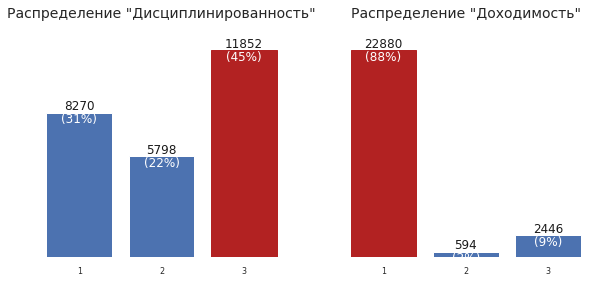

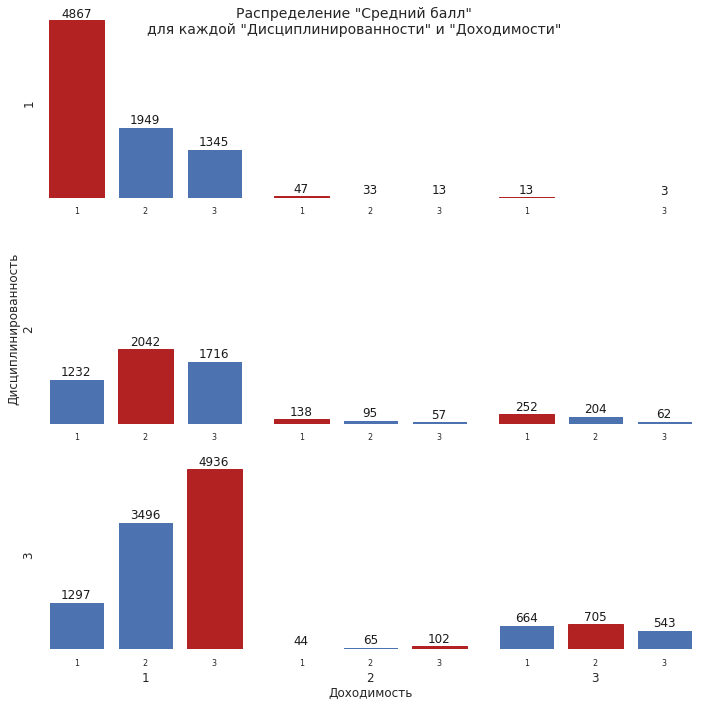

In [125]:
sns.set(style="white")
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Дисциплинированность', 'F':'Доходимость'}
    y = students_rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y)
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Распределение "{}"\n'.format(parameters[p]),
                fontsize=14)
    
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=8)
        
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value,
                '{}'.format(int(value)),
               ha='center',
               va='bottom',
               color='k')
    for bar in bars:
        value = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2,
                value,
                '({}%)'.format(int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=3, ncols=3,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 4)
f_range = range(1, 4)
for r in r_range:
    for f in f_range:
        y = students_rfm[(students_rfm['R'] == r) & (students_rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y)
        if r == 3:
            if f == 2:
                ax.set_xlabel('{}\nДоходимость'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 2:
                ax.set_ylabel('Дисциплинированность\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Распределение "Средний балл"\nдля каждой "Дисциплинированности" и "Доходимости"',
             fontsize=14)
plt.tight_layout()
plt.show()

рисуем график распределения количества студентов по описательным значениям сегментов

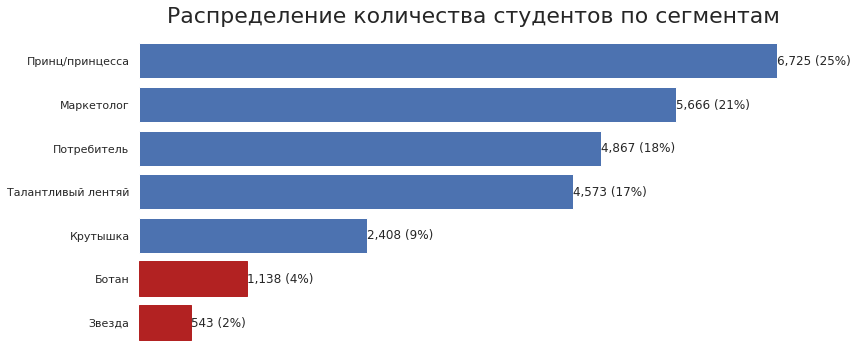

In [126]:
sns.set(rc={'figure.figsize':(12,6)}, style="white")
# count the number of customers in each segment
segments_counts = students_rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts)
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Звезда', 'Ботан']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

# подписываем сам график и оси
plt.title('Распределение количества студентов по сегментам', fontsize = 22)
plt.show()

#### ВЫВОДЫ:
1. У нас 45% студентов, которые сдали все промежуточные тесты, и только 9%, которые сдали итоговый экзамен. То есть с дисциплиной у студентов порядок, но нет особой мотивации сдавать итоговый экзамен. Возможно нужно ввести дополнительный стимул для сдачи экзамена, например, выдачу сертификата о прохождении курса или добавления в отдельное сообщество выпускников с дополнительными плюшками.


2. 


| Сегмент | Что делать |
| --- | --- |
| Принц / принцесса | Самый многочисленный сегмент - 25% Высокие или средние способности. Высокие амбиции. Низкое трудолюбие. Высокая самооценка. Чтобы повысить их доходимость, нужно таким студентам уделять больше внимания, высылать напоминаналки и подбадривающие сообщения, для поддержания их самооценки. |
| Маркетолог | Второй по численности сегмент - 21% Средние или низкие способности. Высокие или средние амбиции. Нормальное или низкое трудолюбие. Адекватная самооценка. Таким студентам во время обучения можно рассылать напоминалки о дэдлайнах и минимальных порогах сдачи. |
| Потребитель | Третий по численности сегмент - 18% Неадекватно высокая самооценка. Неизвестные способности. Отсутствие трудолюбия. За таких студентов можно не бороться, они всегда найдут к чему придраться и еще и негативные отзывы оставят. |
| Талантливый лентяй | Четвертый по численности сегмент - 17% Блестящие способности в потенциале. Кривая мотивация. Импульсивная трудоспособность. Прыгающая самооценка. Заядлый прокрастинатор. Таким студентам можно отправить истории успеха выпускников, чтобы повысить мотивацию. |
| Крутышка | Пятый по численности сегмент - 9% Низкие способности. Огромные амбиции. Высокое трудолюбие. Самооценка зашкаливает. Таким студентам можно рассылать письма с ссылками на доп материалы для изучения, чтобы повысить их успеваемость. |
| Ботан | Шестой по численности сегмент - 4% Блестящие способности. Низкие притязания. Большое трудолюбие. Самооценка средняя или ниже среднего. Самые перспективные студенты.Таким студентам можно высыласть анонсы новых курсов.Особые предложения по оплате. |
| Звезда | Ожидаемо самый малочисленный сегмент - 2% Блестящие способности. Высокие амбиции. Большое трудолюбие. Адекватная самооценка.  Мечта любого преподавателя, гордость и слава альмы-матери. Таким студентам можно высыласть анонсы новых курсов.Особые предложения по оплате. |

---

### проверим теорию, что данные за 2014 год неполные

посчитаем только за 2013 год

In [127]:
students[students["course_name"].str.contains('2014') == False]

,code_module,code_presentation,id_student,date_registration,date_unregistration,exam_passed,score_exam_mean,test_passed,score_test_mean,exam_total_count,test_total_count,course_name,course_passed
0,AAA,2013J,11391,-159.0,NaN,0.0,NaN,5.0,82.000000,1,5,AAA_2013J,0
1,AAA,2013J,28400,-53.0,NaN,0.0,NaN,5.0,66.400000,1,5,AAA_2013J,0
2,AAA,2013J,30268,-92.0,12.0,0.0,NaN,0.0,NaN,1,5,AAA_2013J,0
3,AAA,2013J,31604,-52.0,NaN,0.0,NaN,5.0,76.000000,1,5,AAA_2013J,0
4,AAA,2013J,32885,-176.0,NaN,0.0,NaN,5.0,54.400000,1,5,AAA_2013J,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27395,GGG,2013J,2670570,-38.0,NaN,0.0,NaN,9.0,91.000000,1,9,GGG_2013J,0
27396,GGG,2013J,2673510,3.0,102.0,0.0,NaN,1.0,80.000000,1,9,GGG_2013J,0
27397,GGG,2013J,2674822,-22.0,NaN,0.0,NaN,0.0,NaN,1,9,GGG_2013J,0
27398,GGG,2013J,2679386,-100.0,NaN,0.0,NaN,9.0,90.333333,1,9,GGG_2013J,0


In [128]:
# группируем по студентам, 
# считаем количество начатых курсов, средний балл за тесты и за экзамены, 
# количество экзаменов и тестов, которые студент сдавал, и количество по программе курса
students_summary_2013 = students[students["course_name"].str.contains('2014') == False] \
    .groupby('id_student', as_index = False) \
    .agg({'course_name':'count', 'course_passed':'sum', \
          'score_exam_mean': 'mean', 'exam_passed':'sum', 'exam_total_count':'sum', \
          'score_test_mean': 'mean', 'test_passed':'sum', 'test_total_count':'sum'}) \
    .rename(columns={'course_name':'course_total_count'}) 
students_summary_2013.head()

,id_student,course_total_count,course_passed,score_exam_mean,exam_passed,exam_total_count,score_test_mean,test_passed,test_total_count
0,8462,1,0,NaN,0.0,1,87.666667,3.0,6
1,11391,1,0,NaN,0.0,1,82.000000,5.0,5
2,23629,1,0,NaN,0.0,1,82.500000,4.0,11
3,23798,1,0,NaN,0.0,1,93.909091,11.0,11
4,24391,1,0,NaN,0.0,1,88.888889,9.0,9


In [129]:
# заполняем пустые значения
students_summary_2013['score_exam_mean'] = students_summary_2013['score_exam_mean'].fillna(0)
students_summary_2013['score_test_mean'] = students_summary_2013['score_test_mean'].fillna(0)

In [130]:
# R - дисциплинированность - сколько тестовых работ студент сдал / сколько предусматривается программами курсов 
students_summary_2013['Recency'] = (students_summary_2013['test_passed'] / 
                                    students_summary_2013['test_total_count']) 

# F - доходимость курсов -  сколько курсов закончено / сколько курсов начато
students_summary_2013['Frequency'] = (students_summary_2013['course_passed'] / 
                                      students_summary_2013['course_total_count']) 

# M - среднее количество баллов, получаемое за тесты во время обучения (все виды тестов)
students_summary_2013['Monetary'] = students_summary_2013.apply(get_Monetary, axis=1)

students_summary_2013.head()

,id_student,course_total_count,course_passed,score_exam_mean,exam_passed,exam_total_count,score_test_mean,test_passed,test_total_count,Recency,Frequency,Monetary
0,8462,1,0,0.0,0.0,1,87.666667,3.0,6,0.500000,0.0,87.666667
1,11391,1,0,0.0,0.0,1,82.000000,5.0,5,1.000000,0.0,82.000000
2,23629,1,0,0.0,0.0,1,82.500000,4.0,11,0.363636,0.0,82.500000
3,23798,1,0,0.0,0.0,1,93.909091,11.0,11,1.000000,0.0,93.909091
4,24391,1,0,0.0,0.0,1,88.888889,9.0,9,1.000000,0.0,88.888889


In [131]:
# копируем в новый датафрейм только нужные нам столбцы
students_2013_rfm = students_summary_2013[['id_student','Recency', 'Frequency', 'Monetary']].copy()
students_2013_rfm.head()

,id_student,Recency,Frequency,Monetary
0,8462,0.500000,0.0,87.666667
1,11391,1.000000,0.0,82.000000
2,23629,0.363636,0.0,82.500000
3,23798,1.000000,0.0,93.909091
4,24391,1.000000,0.0,88.888889


In [132]:
#  разбиваем значения на 3 группы quantile([0.33, 0.66])
quantiles = students_2013_rfm[['Recency', 'Frequency', 'Monetary']].quantile([0.33, 0.66]).to_dict()
quantiles

{'Recency': {0.33: 0.5, 0.66: 1.0},
 'Frequency': {0.33: 0.0, 0.66: 0.0},
 'Monetary': {0.33: 65.77777777777777, 0.66: 80.08333333333333}}

In [133]:
def r_score_2013(x):
    if x < 0.5: # сдали < 50% тестов
        return 1
    elif x < 1: # сдали < 100% тестов
        return 2
    else:
        return 3 # сдали все тесты

def f_score_2013(x):
    if x == 0: # не завершили ни один курс
        return 1
    elif x < 1: # завершили несколько, но не все
        return 2
    else:
        return 3 # завершили все курсы

def m_score_2013(x):
    if x <= quantiles['Monetary'][.33]:
        return 1
    elif x <= quantiles['Monetary'][.66]:
        return 2
    else:
        return 3

In [134]:
students_2013_rfm['R'] = students_2013_rfm['Recency'].apply(lambda x: r_score_2013(x))
students_2013_rfm['F'] = students_2013_rfm['Frequency'].apply(lambda x: f_score_2013(x))
students_2013_rfm['M'] = students_2013_rfm['Monetary'].apply(lambda x: m_score_2013(x))

In [135]:
students_2013_rfm.groupby('R')['Recency'].agg(['mean','count'])

,mean,count
R,,
1,0.151804,3799
2,0.775896,2601
3,1.000000,5602


In [136]:
students_2013_rfm.groupby('F')['Frequency'].agg(['mean','count'])

,mean,count
F,,
1,0.0,10432
2,0.5,23
3,1.0,1547


In [137]:
students_2013_rfm.groupby('M')['Monetary'].agg(['mean','count'])

,mean,count
M,,
1,36.060230,3963
2,73.653057,3960
3,86.501504,4079


In [138]:
students_2013_rfm['RFM_Score'] = students_2013_rfm['R'].map(str) + \
    students_2013_rfm['F'].map(str) + \
    students_2013_rfm['M'].map(str)
students_2013_rfm.head()

,id_student,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,8462,0.500000,0.0,87.666667,2,1,3,213
1,11391,1.000000,0.0,82.000000,3,1,3,313
2,23629,0.363636,0.0,82.500000,1,1,3,113
3,23798,1.000000,0.0,93.909091,3,1,3,313
4,24391,1.000000,0.0,88.888889,3,1,3,313


In [139]:
students_2013_rfm.groupby('RFM_Score').agg({'id_student':'count'}).shape

(24, 1)

In [140]:
segt_map = {
    r'333': 'Звезда',
    r'3[2-3][2-3]': 'Ботан',
    r'23[2-3]': 'Ботан',
    r'3[1-3]1': 'Крутышка',
    r'2[2-3]1': 'Крутышка',
    r'131': 'Крутышка',
    r'1[2-3]3': 'Принц/принцесса',
    r'2[1-2]3': 'Принц/принцесса',
    r'313': 'Принц/принцесса',
    r'312': 'Маркетолог',
    r'2[1-2]2': 'Маркетолог',
    r'1[2-3]2': 'Маркетолог',
    r'11[2-3]': 'Талантливый лентяй',
    r'121': 'Талантливый лентяй',
    r'211': 'Талантливый лентяй',
    r'111': 'Потребитель'
}

students_2013_rfm['Segment'] = students_2013_rfm['R'].map(str) + \
    students_2013_rfm['F'].map(str) + students_2013_rfm['M'].map(str)

students_2013_rfm['Segment'] = students_2013_rfm['Segment'].replace(segt_map, regex=True)

students_2013_rfm.groupby('Segment').agg({'id_student':'count'})

,id_student
Segment,
Ботан,571
Звезда,297
Крутышка,1117
Маркетолог,2499
Потребитель,2325
Принц/принцесса,3219
Талантливый лентяй,1974


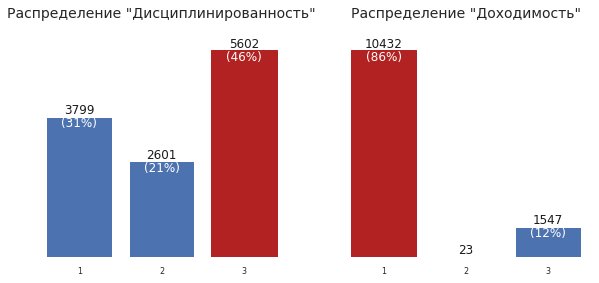

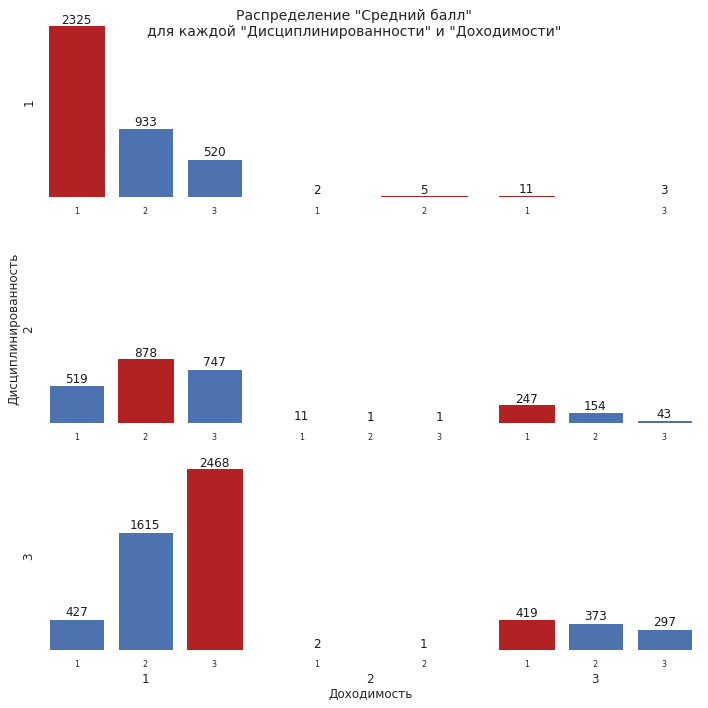

In [141]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Дисциплинированность', 'F':'Доходимость'}
    y = students_2013_rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y)
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Распределение "{}"\n'.format(parameters[p]),
                fontsize=14)
    
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=8)
        
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value,
                '{}'.format(int(value)),
               ha='center',
               va='bottom',
               color='k')
    for bar in bars:
        value = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2,
                value,
                '({}%)'.format(int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=3, ncols=3,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 4)
f_range = range(1, 4)
for r in r_range:
    for f in f_range:
        y = students_2013_rfm[(students_2013_rfm['R'] == r) & 
                              (students_2013_rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y)
        if r == 3:
            if f == 2:
                ax.set_xlabel('{}\nДоходимость'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 2:
                ax.set_ylabel('Дисциплинированность\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Распределение "Средний балл"\nдля каждой "Дисциплинированности" и "Доходимости"',
             fontsize=14)
plt.tight_layout()
plt.show()

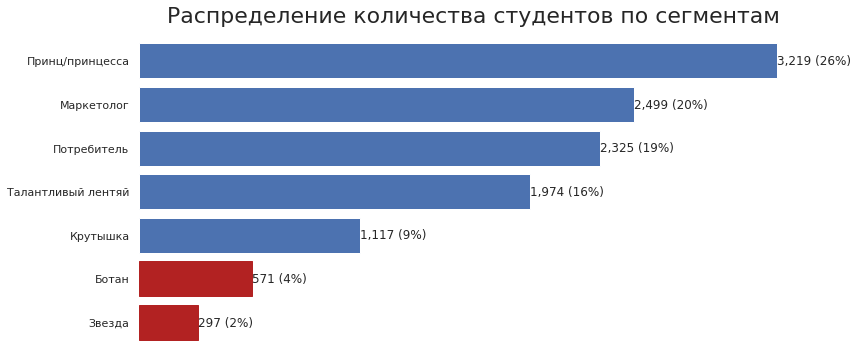

In [142]:
# count the number of customers in each segment
segments_counts = students_2013_rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts)
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Звезда', 'Ботан']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
# подписываем график
plt.title('Распределение количества студентов по сегментам', fontsize = 22)
plt.show()

#### ВЫВОДЫ:
данные за 2013 показали примерно такие же распределения по метрикам, так что версия, что данные за 2014 неполные скорее всего неверна, но чтобы сказать с большей уверенностью требуются дополнительные исследования